In [190]:
import polars as pl
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from scipy import stats
import json

In [3]:
df_answers_1 = pl.read_csv("../answers/answers_1.csv")
df_answers_2 = pl.read_csv("../answers/answers_2.csv")


df_indiviudal_1 = pl.read_csv("../individuals/individuals_1.csv")
df_indiviudal_2 = pl.read_csv("../individuals/individuals_2.csv")


df_properties = pl.read_csv("../statementproperties/statementproperties_1.csv")

df_statements = pl.read_csv("../statements/statements_1.csv")

# 1. Concatenate the two DataFrames vertically
df_answers = pl.concat([df_answers_1, df_answers_2], how="vertical")

# 2. Concatenate the two DataFrames vertically
df_indiviudal = pl.concat([df_indiviudal_1, df_indiviudal_2], how="vertical")

Show the number of unique individuals who answered, each user is assigned a unique sessionId

In [4]:
print(
    "Number of unique individuals: ",
    df_answers.group_by("sessionId")
    .agg(pl.count("sessionId").alias("count"))
    .filter(pl.col("count") >= 15)
    .shape,
)

Number of unique individuals:  (33547, 2)


Convert I_agree and others_agree columns to float, so we can calculate `consensus` and `awareness` values for each statement

In [5]:
df_answers = df_answers.with_columns(
    [pl.col("I_agree").cast(pl.Float64), pl.col("others_agree").cast(pl.Float64)]
)

Now we calculate the `consensus` and `awareness` values for each statement

In [6]:
df_aggs = (
    df_answers.group_by("statementId")
    .agg(
        [
            pl.col("I_agree").mean().alias("mean_I_agree"),
        ]
    )
    .with_columns(
        [
            (2 * (pl.col("mean_I_agree") - 0.5).abs()).alias("c_i"),
            (pl.col("mean_I_agree") >= 0.5).cast(pl.Int8).alias("majority_i"),
        ]
    )
)

df_with_c_and_majority = df_answers.join(
    df_aggs.select(["statementId", "c_i", "majority_i"]), on="statementId"
)

df_with_c_and_majority = df_with_c_and_majority.with_columns(
    [
        (pl.col("others_agree") == pl.col("majority_i"))
        .cast(pl.Int8)
        .alias("matches_majority")
    ]
)


df_final = (
    df_with_c_and_majority.group_by("statementId")
    .agg(
        [
            pl.col("c_i").first().alias("c_i"),
            pl.col("matches_majority").mean().alias("a_i"),
        ]
    )
    .with_columns([(pl.col("c_i") * pl.col("a_i")).sqrt().alias("m_i")])
)

df_final

statementId,c_i,a_i,m_i
i64,f64,f64,f64
2498,0.915254,0.90678,0.911007
9858,0.826087,0.913043,0.868478
3933,0.773913,0.826087,0.799575
3945,0.5,0.75,0.612372
3695,0.52809,0.651685,0.586642
…,…,…,…
4844,0.0,0.5,0.0
3507,1.0,1.0,1.0
3126,1.0,0.99187,0.995927


In [7]:
df_median = df_answers.group_by("statementId").agg(
    pl.col("I_agree").median().alias("median_I_agree")
)

df_joined = df_answers.join(df_median, on="statementId", how="left")

df_joined = df_joined.with_columns(
    [
        (pl.col("I_agree") == pl.col("median_I_agree"))
        .cast(pl.Float64)
        .alias("is_consensus"),
        pl.when(pl.col("median_I_agree") == 0.5)
        .then(1.0)
        .otherwise(
            (pl.col("others_agree") == pl.col("median_I_agree")).cast(pl.Float64)
        )
        .alias("is_aware"),
    ]
)

df_joined.head(4)

id,I_agree,I_agree_reason,others_agree,others_agree_reason,perceived_commonsense,clarity,origLanguage,sessionId,createdAt,updatedAt,statement_number,statementId,clientVersion,median_I_agree,is_consensus,is_aware
i64,f64,str,f64,str,i64,str,str,str,str,str,i64,i64,str,f64,f64,f64
1,1.0,"""It's obvious""",1.0,"""I think most people have good …",1,"""Clear: it is clearly written a…","""en""","""uZBSJf5x8X7I1vvwiX4K7YfrB7hY_t…","""2023-06-14 17:11:11""","""2023-06-14 17:11:11""",6,6,null,1.0,1.0,1.0
2,1.0,"""It's something I learned""",1.0,"""I think most people have good …",1,"""Clear: it is clearly written a…","""en""","""siFSQa8F_h3woRq5maLEsmoDQmA-ws…","""2023-06-14 17:11:17""","""2023-06-14 17:11:17""",6,6,null,1.0,1.0,1.0
3,1.0,"""It's something I learned""",1.0,"""I think most people have good …",1,"""Clear: it is clearly written a…","""en""","""7A2Xy3lMfn_Pe12DeucuE-1swxAv34…","""2023-06-14 17:11:23""","""2023-06-14 17:11:23""",6,6,null,1.0,1.0,1.0
4,1.0,"""It's obvious""",1.0,"""I think most people lack good …",0,"""Clear: it is clearly written a…","""en""","""n4yeiqY8p1DDUmxhKphavobA-w5LCn…","""2023-06-14 17:11:27""","""2023-06-14 17:11:27""",149,149,null,1.0,1.0,1.0


In [8]:
df_session = (
    df_joined.group_by("sessionId")
    .agg(
        [
            pl.col("is_consensus").mean().alias("consensus"),
            pl.col("is_aware").mean().alias("awareness"),
            pl.len().alias("response_count"),
        ]
    )
    .filter(pl.col("response_count") > 5)
    .with_columns(
        (pl.col("awareness") * pl.col("consensus")).sqrt().alias("commonsensicality")
    )
)

df_session = df_session.with_columns(
    ((pl.col("awareness") * pl.col("consensus")).sqrt()).alias("commonsensicality")
)

df_session

sessionId,consensus,awareness,response_count,commonsensicality
str,f64,f64,u32,f64
"""j6UR4Q5viZfpJUzAkJ9bt_HER-iNvZ…",0.857143,1.0,14,0.92582
"""zve7dO_BJgxixZFXV7jqjN2fqAfp9e…",0.6,0.733333,15,0.663325
"""FmZi9CUVoEjjxypeH1IbTp0-4yHRAe…",0.857143,0.714286,14,0.782461
"""LaewfL-MJmh-Z_HhUC8eiVOU7Vv-fi…",1.0,0.666667,6,0.816497
"""33V6QFq9VhbRic-vEILYsUqvTBxmiz…",0.8,0.733333,15,0.765942
…,…,…,…,…
"""9ZfSVydxNrQxdfKleE9Gl36NB19d-H…",0.933333,0.933333,15,0.933333
"""AMBDQeqbmcJkcih1pg5dAjauJEwhsN…",0.428571,1.0,7,0.654654
"""4gtp6MJQR-Xudt4AK-UcopCBwyjXrU…",1.0,0.785714,14,0.886405


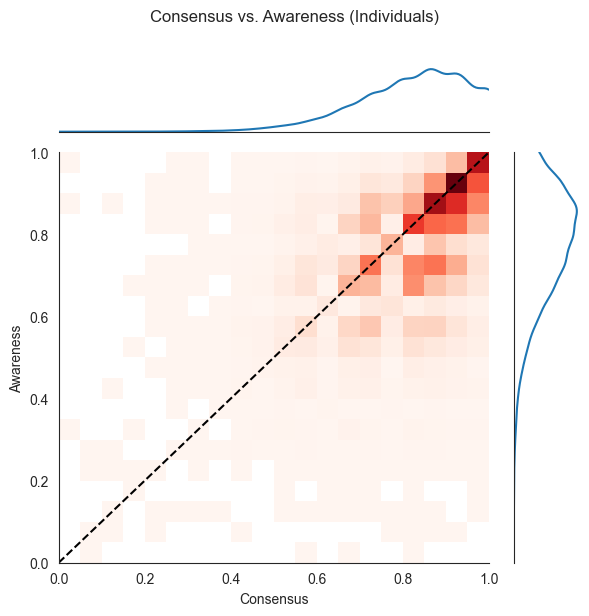

In [9]:
# json.loads(df_indiviudal[100].select("experimentInfo").to_numpy()[0][0])

df_pandas = df_session.to_pandas()

sns.set_style("white")

# Create an empty JointGrid
g = sns.JointGrid(data=df_pandas, x="consensus", y="awareness")

# Plot the 2D histogram in the center
g.plot_joint(sns.histplot, bins=20, cmap="Reds")

# Plot the marginals as line-based KDE curves
g.plot_marginals(
    sns.kdeplot,
    fill=False,        # no fill, just the line
    bw_adjust=2,     # increase bandwidth to smooth
    cut=0,             # don't extend the curve beyond the data
    clip=(0, 1)        # limit KDE to [0,1] (assuming consensus/awareness in [0,1])
)

# Add the reference diagonal
g.ax_joint.plot([0, 1], [0, 1], ls="--", color="black")

# Adjust axes and labels
g.ax_joint.set_xlim(0, 1)
g.ax_joint.set_ylim(0, 1)
g.set_axis_labels("Consensus", "Awareness")

# Title and layout
plt.suptitle("Consensus vs. Awareness (Individuals)", y=1.02)
plt.tight_layout()
plt.savefig("figures/consensus_vs_awareness_individuals.pdf", dpi=300, bbox_inches="tight")

In [10]:
df_properties

id,name,available,createdAt,updatedAt,statementId
i64,str,i64,str,str,i64
1,"""behavior""",0,"""2023-04-08 12:23:26""","""2023-04-08 12:23:26""",1
2,"""everyday""",1,"""2023-04-08 12:23:26""","""2023-04-08 12:23:26""",1
3,"""figure_of_speech""",0,"""2023-04-08 12:23:26""","""2023-04-08 12:23:26""",1
4,"""judgment""",0,"""2023-04-08 12:23:26""","""2023-04-08 12:23:26""",1
5,"""opinion""",0,"""2023-04-08 12:23:26""","""2023-04-08 12:23:26""",1
…,…,…,…,…,…
60656,"""everyday""",1,"""2025-02-18 14:49:40""","""2025-02-18 14:49:40""",8859
60657,"""figure_of_speech""",0,"""2025-02-18 14:49:40""","""2025-02-18 14:49:40""",8859
60658,"""judgment""",1,"""2025-02-18 14:49:40""","""2025-02-18 14:49:40""",8859


In [11]:
properties_wide = df_properties.pivot(
    index="statementId",
    columns="name",
    values="available",
)

properties_wide

/var/folders/5j/9pnb21r14qjbflhqq7gq72lr0000gn/T/ipykernel_9720/1597815251.py:1: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.
  properties_wide = df_properties.pivot(


statementId,behavior,everyday,figure_of_speech,judgment,opinion,reasoning
i64,i64,i64,i64,i64,i64,i64
1,0,1,0,0,0,1
2,0,0,0,0,0,0
3,1,1,0,1,0,1
4,0,1,0,0,0,0
5,0,1,0,1,1,0
…,…,…,…,…,…,…
8855,1,1,0,1,1,1
8856,1,1,0,1,1,1
8857,1,1,0,1,1,1


In [12]:
joined_answer_df = df_joined.join(
    properties_wide, 
    on="statementId",   
    how="inner"         
)

joined_answer_df

id,I_agree,I_agree_reason,others_agree,others_agree_reason,perceived_commonsense,clarity,origLanguage,sessionId,createdAt,updatedAt,statement_number,statementId,clientVersion,median_I_agree,is_consensus,is_aware,behavior,everyday,figure_of_speech,judgment,opinion,reasoning
i64,f64,str,f64,str,i64,str,str,str,str,str,i64,i64,str,f64,f64,f64,i64,i64,i64,i64,i64,i64
1,1.0,"""It's obvious""",1.0,"""I think most people have good …",1,"""Clear: it is clearly written a…","""en""","""uZBSJf5x8X7I1vvwiX4K7YfrB7hY_t…","""2023-06-14 17:11:11""","""2023-06-14 17:11:11""",6,6,null,1.0,1.0,1.0,0,1,0,0,1,1
2,1.0,"""It's something I learned""",1.0,"""I think most people have good …",1,"""Clear: it is clearly written a…","""en""","""siFSQa8F_h3woRq5maLEsmoDQmA-ws…","""2023-06-14 17:11:17""","""2023-06-14 17:11:17""",6,6,null,1.0,1.0,1.0,0,1,0,0,1,1
3,1.0,"""It's something I learned""",1.0,"""I think most people have good …",1,"""Clear: it is clearly written a…","""en""","""7A2Xy3lMfn_Pe12DeucuE-1swxAv34…","""2023-06-14 17:11:23""","""2023-06-14 17:11:23""",6,6,null,1.0,1.0,1.0,0,1,0,0,1,1
4,1.0,"""It's obvious""",1.0,"""I think most people lack good …",0,"""Clear: it is clearly written a…","""en""","""n4yeiqY8p1DDUmxhKphavobA-w5LCn…","""2023-06-14 17:11:27""","""2023-06-14 17:11:27""",149,149,null,1.0,1.0,1.0,0,0,1,1,0,1
5,0.0,"""I don't know""",0.0,"""I don't know""",0,"""Confusing: I don't quite under…","""en""","""uZBSJf5x8X7I1vvwiX4K7YfrB7hY_t…","""2023-06-14 17:11:34""","""2023-06-14 17:11:34""",149,149,null,1.0,0.0,0.0,0,0,1,1,0,1
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
793038,1.0,"""It's my opinion""",1.0,"""I think most people have good …",1,null,"""en""","""r5P3karHQRT9a9fPQei8cXU1UijCCZ…","""2025-04-02 14:52:09""","""2025-04-02 14:52:09""",9366,9366,"""bbcd5d5""",1.0,1.0,1.0,1,0,0,1,1,0
793039,1.0,"""It's obvious""",1.0,"""I think it's mostly a matter o…",1,null,"""en""","""r5P3karHQRT9a9fPQei8cXU1UijCCZ…","""2025-04-02 14:52:39""","""2025-04-02 14:52:39""",9525,9525,"""bbcd5d5""",1.0,1.0,1.0,1,1,0,1,1,0
793040,1.0,"""It's obvious""",1.0,"""I think most people have good …",1,null,"""en""","""r5P3karHQRT9a9fPQei8cXU1UijCCZ…","""2025-04-02 14:53:14""","""2025-04-02 14:53:14""",9941,9941,"""bbcd5d5""",1.0,1.0,1.0,1,0,0,1,1,0


In [13]:
medians_means = (
    joined_answer_df
    .group_by("statementId")
    .agg([
        pl.col("I_agree").median().alias("median_i_agree"),
        pl.col("I_agree").mean().alias("mean_i_agree"),
    ])
)

medians_means.head(3)

statementId,median_i_agree,mean_i_agree
i64,f64,f64
4219,1.0,1.0
9188,1.0,0.945055
9831,1.0,0.939394


In [14]:
answers_with_medians = joined_answer_df.join(medians_means, on="statementId")
answers_with_medians.head(3)

id,I_agree,I_agree_reason,others_agree,others_agree_reason,perceived_commonsense,clarity,origLanguage,sessionId,createdAt,updatedAt,statement_number,statementId,clientVersion,median_I_agree,is_consensus,is_aware,behavior,everyday,figure_of_speech,judgment,opinion,reasoning,median_i_agree,mean_i_agree
i64,f64,str,f64,str,i64,str,str,str,str,str,i64,i64,str,f64,f64,f64,i64,i64,i64,i64,i64,i64,f64,f64
1,1.0,"""It's obvious""",1.0,"""I think most people have good …",1,"""Clear: it is clearly written a…","""en""","""uZBSJf5x8X7I1vvwiX4K7YfrB7hY_t…","""2023-06-14 17:11:11""","""2023-06-14 17:11:11""",6,6,null,1.0,1.0,1.0,0,1,0,0,1,1,1.0,0.965517
2,1.0,"""It's something I learned""",1.0,"""I think most people have good …",1,"""Clear: it is clearly written a…","""en""","""siFSQa8F_h3woRq5maLEsmoDQmA-ws…","""2023-06-14 17:11:17""","""2023-06-14 17:11:17""",6,6,null,1.0,1.0,1.0,0,1,0,0,1,1,1.0,0.965517
3,1.0,"""It's something I learned""",1.0,"""I think most people have good …",1,"""Clear: it is clearly written a…","""en""","""7A2Xy3lMfn_Pe12DeucuE-1swxAv34…","""2023-06-14 17:11:23""","""2023-06-14 17:11:23""",6,6,null,1.0,1.0,1.0,0,1,0,0,1,1,1.0,0.965517


In [15]:
answers_with_awareness = answers_with_medians.with_columns(
    pl.when(pl.col("median_i_agree") == 0.5)
    .then(pl.lit(1.0))
    .otherwise((pl.col("others_agree") == pl.col("median_i_agree")).cast(pl.Float64()))
    .alias("awareness_row")
)

In [16]:
answers_with_awareness.head(3)

id,I_agree,I_agree_reason,others_agree,others_agree_reason,perceived_commonsense,clarity,origLanguage,sessionId,createdAt,updatedAt,statement_number,statementId,clientVersion,median_I_agree,is_consensus,is_aware,behavior,everyday,figure_of_speech,judgment,opinion,reasoning,median_i_agree,mean_i_agree,awareness_row
i64,f64,str,f64,str,i64,str,str,str,str,str,i64,i64,str,f64,f64,f64,i64,i64,i64,i64,i64,i64,f64,f64,f64
1,1.0,"""It's obvious""",1.0,"""I think most people have good …",1,"""Clear: it is clearly written a…","""en""","""uZBSJf5x8X7I1vvwiX4K7YfrB7hY_t…","""2023-06-14 17:11:11""","""2023-06-14 17:11:11""",6,6,null,1.0,1.0,1.0,0,1,0,0,1,1,1.0,0.965517,1.0
2,1.0,"""It's something I learned""",1.0,"""I think most people have good …",1,"""Clear: it is clearly written a…","""en""","""siFSQa8F_h3woRq5maLEsmoDQmA-ws…","""2023-06-14 17:11:17""","""2023-06-14 17:11:17""",6,6,null,1.0,1.0,1.0,0,1,0,0,1,1,1.0,0.965517,1.0
3,1.0,"""It's something I learned""",1.0,"""I think most people have good …",1,"""Clear: it is clearly written a…","""en""","""7A2Xy3lMfn_Pe12DeucuE-1swxAv34…","""2023-06-14 17:11:23""","""2023-06-14 17:11:23""",6,6,null,1.0,1.0,1.0,0,1,0,0,1,1,1.0,0.965517,1.0


In [17]:
statement_commonsense = (
    answers_with_awareness.group_by("statementId")
    .agg(
        [
            pl.col("awareness_row").mean().alias("statement_awareness"),
            pl.col("mean_i_agree").mean().alias("mean_of_mean_i_agree"),
        ]
    )
    .with_columns(
        [(2 * (pl.col("mean_of_mean_i_agree") - 0.5).abs()).alias("statement_consensus")]
    )
    .with_columns(
        [
            (pl.col("statement_awareness") * pl.col("statement_consensus"))
            .sqrt()
            .alias("actual_commonsensicality")
        ]
    )
    .select(["statementId", "statement_awareness", "statement_consensus", "actual_commonsensicality"])
)

In [18]:
statement_commonsense

statementId,statement_awareness,statement_consensus,actual_commonsensicality
i64,f64,f64,f64
9066,0.942396,0.861751,0.901172
3311,1.0,1.0,1.0
9069,0.532258,0.617512,0.573302
9581,0.298701,0.142857,0.206571
2254,0.813953,0.72093,0.766031
…,…,…,…
7568,1.0,1.0,1.0
4290,0.972727,0.890909,0.93092
2989,0.444444,0.206349,0.302838


In [19]:
statement_commonsensicality_with_properties = statement_commonsense.join(properties_wide, on="statementId", how="left")

# statement_commonsensicality_with_properties

In [20]:
statement_commonsensicality_with_properties

statementId,statement_awareness,statement_consensus,actual_commonsensicality,behavior,everyday,figure_of_speech,judgment,opinion,reasoning
i64,f64,f64,f64,i64,i64,i64,i64,i64,i64
9066,0.942396,0.861751,0.901172,1,0,0,1,1,1
3311,1.0,1.0,1.0,1,0,0,0,0,1
9069,0.532258,0.617512,0.573302,1,0,0,1,1,1
9581,0.298701,0.142857,0.206571,0,0,0,0,0,0
2254,0.813953,0.72093,0.766031,1,1,0,0,0,1
…,…,…,…,…,…,…,…,…,…
7568,1.0,1.0,1.0,0,1,0,1,1,1
4290,0.972727,0.890909,0.93092,1,1,0,1,0,0
2989,0.444444,0.206349,0.302838,0,1,0,1,0,1


In [21]:
long_df = statement_commonsensicality_with_properties.unpivot(
    index=["statementId", "actual_commonsensicality"],
    on=[
        "behavior",
        "everyday",
        "figure_of_speech",
        "judgment",
        "opinion",
        "reasoning",
    ],
    variable_name="property_name",
    value_name="has_property",
)

In [22]:
import numpy as np

boot_res = []

n_boot = 500
prop_list = [
    "behavior",
    "everyday",
    "figure_of_speech",
    "judgment",
    "opinion",
    "reasoning",
]

for prop in prop_list:

    true_vals = long_df.filter(
        (pl.col("property_name") == prop) & (pl.col("has_property") == 1)
    )["actual_commonsensicality"].to_numpy()
    false_vals = long_df.filter(
        (pl.col("property_name") == prop) & (pl.col("has_property") == 0)
    )["actual_commonsensicality"].to_numpy()

    nT = len(true_vals)
    nF = len(false_vals)
    for _ in range(n_boot):
        sample_T = np.random.choice(true_vals, size=nT, replace=True)
        sample_F = np.random.choice(false_vals, size=nF, replace=True)
        mean_diff = sample_T.mean() - sample_F.mean()
        boot_res.append((prop, mean_diff))


boot_df = pl.DataFrame(boot_res, schema=["property_name", "difference_mean"])

/var/folders/5j/9pnb21r14qjbflhqq7gq72lr0000gn/T/ipykernel_9720/3102902135.py:33: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  boot_df = pl.DataFrame(boot_res, schema=["property_name", "difference_mean"])


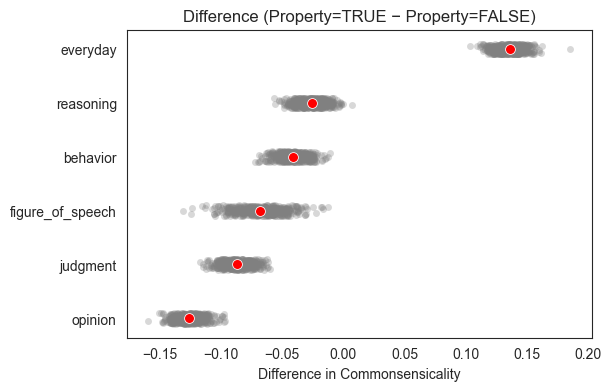

In [23]:
mean_diffs = (
    boot_df.group_by("property_name")
    .agg(pl.col("difference_mean").mean().alias("mean_diff"))
    .sort("mean_diff", descending=True)
)

mean_df_pd = mean_diffs.to_pandas()

cat_order = mean_df_pd["property_name"].tolist()


plt.figure(figsize=(6, 4))


sns.stripplot(
    data=boot_df.to_pandas(),
    x="difference_mean",
    y="property_name",
    alpha=0.3,
    color="gray",
    order=cat_order,
)

sns.scatterplot(
    data=mean_df_pd,
    x="mean_diff",
    y="property_name",
    color="red",
    s=50,
    zorder=10,
    hue_order=cat_order,
)


plt.xlabel("Difference in Commonsensicality")
plt.ylabel("")
plt.title("Difference (Property=TRUE − Property=FALSE)")
plt.show()

In [24]:
statement_commonsensicality_with_properties

statementId,statement_awareness,statement_consensus,actual_commonsensicality,behavior,everyday,figure_of_speech,judgment,opinion,reasoning
i64,f64,f64,f64,i64,i64,i64,i64,i64,i64
9066,0.942396,0.861751,0.901172,1,0,0,1,1,1
3311,1.0,1.0,1.0,1,0,0,0,0,1
9069,0.532258,0.617512,0.573302,1,0,0,1,1,1
9581,0.298701,0.142857,0.206571,0,0,0,0,0,0
2254,0.813953,0.72093,0.766031,1,1,0,0,0,1
…,…,…,…,…,…,…,…,…,…
7568,1.0,1.0,1.0,0,1,0,1,1,1
4290,0.972727,0.890909,0.93092,1,1,0,1,0,0
2989,0.444444,0.206349,0.302838,0,1,0,1,0,1


In [25]:
category_plot_df = statement_commonsensicality_with_properties.join(
    df_statements, left_on="statementId", right_on="id", how="left"
)

In [26]:
category_means = (
    category_plot_df.group_by("statementCategory")
    .agg([pl.col("actual_commonsensicality").mean().alias("mean_commonsensicality")])
    .sort("mean_commonsensicality",descending=True)
)


cat_means_pd = category_means.to_pandas()
cat_order = cat_means_pd["statementCategory"].tolist()

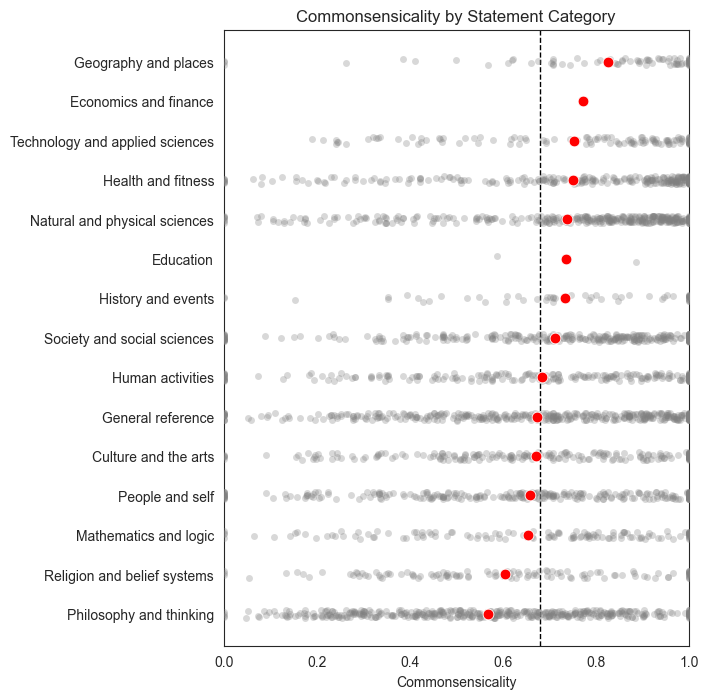

In [27]:
plot_df_pd = category_plot_df.to_pandas()

plt.figure(figsize=(6, 8))


ax = sns.stripplot(
    data=plot_df_pd,
    x="actual_commonsensicality",
    y="statementCategory",
    order=cat_order,
    alpha=0.3,
    color="gray",
    jitter=True,
)


mean_points_pd = cat_means_pd.rename(columns={"mean_commonsensicality": "x"})
sns.scatterplot(
    data=mean_points_pd,
    x="x",
    y="statementCategory",
    hue_order=cat_order,
    color="red",
    s=60,
    zorder=10,
    ax=ax,
)


overall_mean = plot_df_pd["actual_commonsensicality"].mean()

plt.axvline(x=overall_mean, color="black", linestyle="--", linewidth=1)

plt.xlim(0, 1)
plt.xlabel("Commonsensicality")
plt.ylabel("")
plt.title("Commonsensicality by Statement Category")
plt.show()

## Design point average commonsensicality

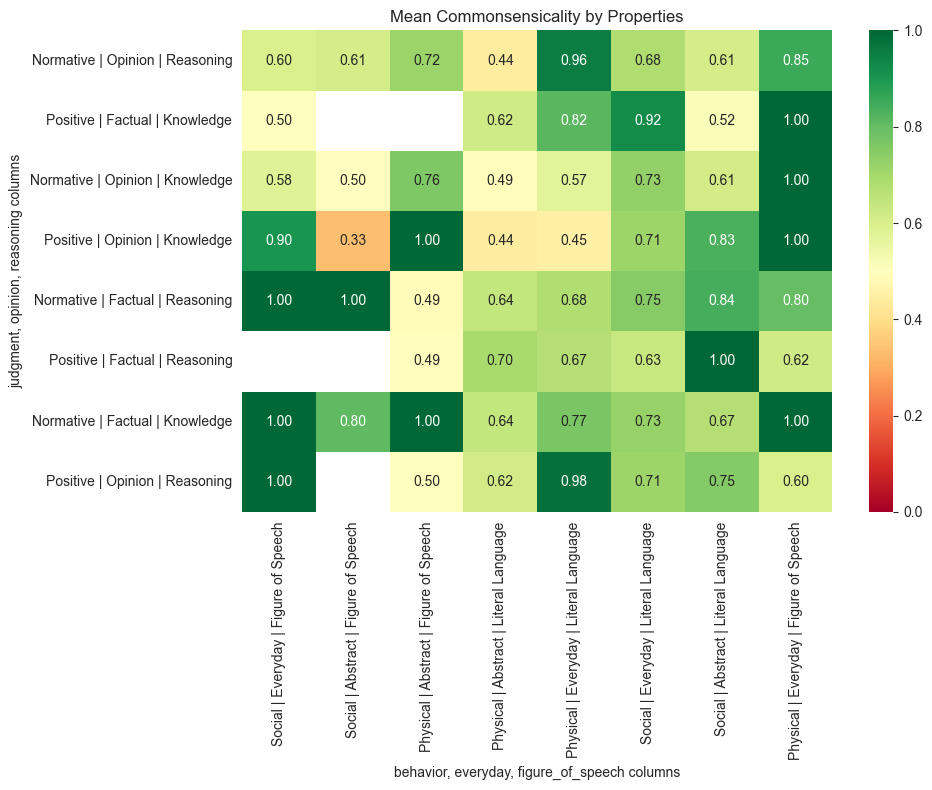

In [28]:
replace_dict = {
    "behavior": {"Physical": 0, "Social": 1},
    "everyday": {"Abstract": 0, "Everyday": 1},
    "figure_of_speech": {"Literal Language": 0, "Figure of Speech": 1},
    "judgment": {"Positive": 0, "Normative": 1},
    "opinion": {"Factual": 0, "Opinion": 1},
    "reasoning": {"Knowledge": 0, "Reasoning": 1},
}
inv_replace_dict = {
    col: {v: k for k, v in mapping.items()} for col, mapping in replace_dict.items()
}


df_replaced = statement_commonsensicality_with_properties

for col in inv_replace_dict.keys():
    df_replaced = df_replaced.with_columns(
        pl.col(col)
        .map_elements(
            lambda x: inv_replace_dict[col].get(x, f"Unmapped_{x}"),
            return_dtype=pl.String,
        )
        .alias(col)
    )

df_with_labels = df_replaced.with_columns(
    [
        pl.format(
            "{} | {} | {}",
            pl.col("behavior"),
            pl.col("everyday"),
            pl.col("figure_of_speech"),
        ).alias("x_label"),
        pl.format(
            "{} | {} | {}", pl.col("judgment"), pl.col("opinion"), pl.col("reasoning")
        ).alias("y_label"),
    ]
)

df_heat = (
    df_with_labels.group_by(["x_label", "y_label"])
    .agg([pl.col("actual_commonsensicality").mean().alias("avg_commonsensicality")])
    .pivot(
        index="y_label",
        on="x_label",
        values="avg_commonsensicality",
    )
)

df_heat_pd = df_heat.to_pandas()


df_heat_pd = df_heat_pd.set_index("y_label")

plt.figure(figsize=(10, 8))

sns.heatmap(
    df_heat_pd,
    cmap="RdYlGn",
    vmin=0,
    vmax=1,
    annot=True,
    fmt=".2f",
)

plt.title("Mean Commonsensicality by Properties")
plt.xlabel("behavior, everyday, figure_of_speech columns")
plt.ylabel("judgment, opinion, reasoning columns")
plt.tight_layout()
plt.show()

In [29]:
df_indiviudal

id,userSessionId,informationType,experimentInfo,urlParams,finished,createdAt,updatedAt
i64,str,str,str,str,i64,str,str
1,"""FkNLAgvZVY9w_7ZdMSlLg7FGlbuttt…","""CRT""","""{""surveySource"":""@watts-lab/su…",null,1,"""2024-04-23 17:48:36""","""2024-04-23 17:48:36"""
2,"""FkNLAgvZVY9w_7ZdMSlLg7FGlbuttt…","""rmeTen""","""{""surveySource"":""@watts-lab/su…",null,1,"""2024-04-23 17:49:01""","""2024-04-23 17:49:01"""
3,"""FkNLAgvZVY9w_7ZdMSlLg7FGlbuttt…","""demographics""","""{""surveySource"":""@watts-lab/su…",null,1,"""2024-04-23 17:49:41""","""2024-04-23 17:49:41"""
4,"""l4JyCjo2Mq0huM9-Z78JRvxO3bERBK…","""CRT""","""{""surveySource"":""@watts-lab/su…",null,1,"""2024-05-29 17:56:59""","""2024-05-29 17:56:59"""
5,"""l4JyCjo2Mq0huM9-Z78JRvxO3bERBK…","""rmeTen""","""{""surveySource"":""@watts-lab/su…",null,1,"""2024-05-29 17:57:14""","""2024-05-29 17:57:14"""
…,…,…,…,…,…,…,…
125122,"""QI0gHKHJJXm9iJfWTE9lIj7QICEldy…","""rmeTen""","""{""surveySource"":""@watts-lab/su…",null,1,"""2025-04-01 19:34:13""","""2025-04-01 19:34:13"""
125123,"""QI0gHKHJJXm9iJfWTE9lIj7QICEldy…","""demographicsLongInternational""","""{""surveySource"":""@watts-lab/su…",null,1,"""2025-04-01 19:35:56""","""2025-04-01 19:35:56"""
125124,"""r5P3karHQRT9a9fPQei8cXU1UijCCZ…","""CRT""","""{""surveySource"":""@watts-lab/su…",null,1,"""2025-04-02 15:02:22""","""2025-04-02 15:02:22"""


In [30]:
df_inidivial_pivoted = df_indiviudal.pivot(
    index="userSessionId",
    on="informationType",
    values="experimentInfo",
    aggregate_function="first"
)

df_inidivial_pivoted

userSessionId,CRT,rmeTen,demographics,demographicsLongInternational
str,str,str,str,str
"""FkNLAgvZVY9w_7ZdMSlLg7FGlbuttt…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null
"""l4JyCjo2Mq0huM9-Z78JRvxO3bERBK…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null
"""ZT_ckkMnCIWKaeFQtEjEdiIpFjx2xk…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null
"""VPgzPGNjKA4_OQ5VJvvEKyeoAe2DpZ…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null
"""wx2DpRTkgySjtK2a8sgKVRHV_hi-F7…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null
…,…,…,…,…
"""mTZFe2dcTT6SlgCL4eB8qsLNyD8wJh…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""{""surveySource"":""@watts-lab/su…"
"""LpiE-djY1nQcWq0IjhRw6Ju7LLKH71…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""{""surveySource"":""@watts-lab/su…"
"""X-zE6VSo7ZLOetS8lV9T7qjCHz9gkC…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""{""surveySource"":""@watts-lab/su…"


In [31]:
df_with_crt = df_indiviudal.pivot(
    index="userSessionId",
    on="informationType",
    values="createdAt",
    aggregate_function="first"
)

df_inidivial_pivoted = df_inidivial_pivoted.join(df_with_crt, on="userSessionId", how="inner")


In [32]:
df_inidivial_pivoted.filter(
    pl.col("demographics").is_not_null()
    & pl.col("demographicsLongInternational").is_null()
)

userSessionId,CRT,rmeTen,demographics,demographicsLongInternational,CRT_right,rmeTen_right,demographics_right,demographicsLongInternational_right
str,str,str,str,str,str,str,str,str
"""FkNLAgvZVY9w_7ZdMSlLg7FGlbuttt…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-04-23 17:48:36""","""2024-04-23 17:49:01""","""2024-04-23 17:49:41""",null
"""l4JyCjo2Mq0huM9-Z78JRvxO3bERBK…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-05-29 17:56:59""","""2024-05-29 17:57:14""","""2024-05-29 17:57:18""",null
"""ZT_ckkMnCIWKaeFQtEjEdiIpFjx2xk…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-05-31 16:27:30""","""2024-05-31 16:28:06""","""2024-05-31 16:29:07""",null
"""VPgzPGNjKA4_OQ5VJvvEKyeoAe2DpZ…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-05-31 16:58:16""","""2024-05-31 16:58:25""","""2024-05-31 16:58:36""",null
"""wx2DpRTkgySjtK2a8sgKVRHV_hi-F7…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-06-06 16:50:40""","""2024-06-06 16:51:13""","""2024-06-06 16:52:13""",null
…,…,…,…,…,…,…,…,…
"""iyE8Q-Hq54GCMtOYlzBvUHfEAq_Oyr…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2025-01-14 21:59:50""","""2025-01-14 22:01:16""","""2025-01-14 22:01:55""",null
"""NvsQs6nVeQJQ42gDnTQnuWiJUVoRPs…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2025-01-15 01:06:37""","""2025-01-15 01:07:59""","""2025-01-15 01:08:57""",null
"""COQN5Y4-ppLuwdccoKWRqPFs6de7Yr…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2025-01-15 01:21:04""","""2025-01-15 01:44:13""","""2025-01-15 01:46:13""",null


In [33]:
df_inidivial_pivoted.filter(
    pl.col("demographics").is_null()
    & pl.col("demographicsLongInternational").is_not_null()
)

userSessionId,CRT,rmeTen,demographics,demographicsLongInternational,CRT_right,rmeTen_right,demographics_right,demographicsLongInternational_right
str,str,str,str,str,str,str,str,str
"""yUfJswvhfTgY5NDQfXpx7q_Vy7iPXX…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""{""surveySource"":""@watts-lab/su…","""2025-01-17 18:03:50""","""2025-01-17 18:04:13""",null,"""2025-01-17 18:04:45"""
"""ZvL0KmZG99yXp5MAewAapBRK7Y6PoY…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""{""surveySource"":""@watts-lab/su…","""2025-01-17 20:30:57""","""2025-01-17 20:32:45""",null,"""2025-01-17 20:34:41"""
"""Qt2_Z0v0DTTt6XZ9eMEAWWPRPTrZQb…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""{""surveySource"":""@watts-lab/su…","""2025-01-19 11:13:09""","""2025-01-19 11:14:47""",null,"""2025-01-19 11:16:26"""
"""CranewGsPv_jk5SinY_dHzLCVFxYkY…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""{""surveySource"":""@watts-lab/su…","""2025-01-19 20:04:15""","""2025-01-19 20:07:19""",null,"""2025-01-19 20:09:12"""
"""LpybvN9troXTId5wYSOiZygOp95h_G…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""{""surveySource"":""@watts-lab/su…","""2025-01-19 22:04:56""","""2025-01-19 22:06:52""",null,"""2025-01-19 22:10:09"""
…,…,…,…,…,…,…,…,…
"""mTZFe2dcTT6SlgCL4eB8qsLNyD8wJh…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""{""surveySource"":""@watts-lab/su…","""2025-03-25 11:22:11""","""2025-03-25 11:23:43""",null,"""2025-03-25 11:25:41"""
"""LpiE-djY1nQcWq0IjhRw6Ju7LLKH71…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""{""surveySource"":""@watts-lab/su…","""2025-03-25 18:02:45""","""2025-03-25 18:05:16""",null,"""2025-03-25 18:06:12"""
"""X-zE6VSo7ZLOetS8lV9T7qjCHz9gkC…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""{""surveySource"":""@watts-lab/su…","""2025-03-28 15:54:51""","""2025-03-28 15:56:11""",null,"""2025-03-28 15:57:05"""


## Commonsensicality by country

A figure that shows the statement commonsensicality by dimension for top countries where the users are from.

In [34]:
import ast

df_filtered = df_inidivial_pivoted.filter(
    pl.col("demographics").is_not_null()
    & pl.col("demographicsLongInternational").is_null()
)


df_with_crt = df_filtered.with_columns(
    [
        pl.col("CRT")
        .map_elements(
            lambda x: ast.literal_eval(x)["result"]["score"] if x is not None else None,
            return_dtype=pl.Float64,
        )
        .alias("crt_score"),
        pl.col("rmeTen")
        .map_elements(
            lambda x: ast.literal_eval(x)["result"]["score"] if x is not None else None,
            return_dtype=pl.Float64,
        )
        .alias("rmeTen_score"),
        pl.col("demographics")
        .map_elements(
            lambda x: (
                ast.literal_eval(x)["responses"].get("birth_year")
                if x is not None
                else None
            ),
            return_dtype=pl.String,
        )
        .alias("birth_year"),
        pl.col("demographics")
        .map_elements(
            lambda x: (
                ast.literal_eval(x)["responses"].get("gender")
                if x is not None
                else None
            ),
            return_dtype=pl.String,
        )
        .alias("gender"),
        pl.col("demographics")
        .map_elements(
            lambda x: (
                ast.literal_eval(x)["responses"].get("marital_status")
                if x is not None
                else None
            ),
            return_dtype=pl.String,
        )
        .alias("marital_status"),
        pl.col("demographics")
        .map_elements(
            lambda x: (
                ast.literal_eval(x)["responses"].get("language_primary")
                if x is not None
                else None
            ),
            return_dtype=pl.String,
        )
        .alias("language_primary"),
        pl.col("demographics")
        .map_elements(
            lambda x: (
                ast.literal_eval(x)["responses"].get("english_written")
                if x is not None
                else None
            ),
            return_dtype=pl.Int64,
        )
        .alias("english_written"),
        pl.col("demographics")
        .map_elements(
            lambda x: (
                ast.literal_eval(x)["responses"].get("english_spoken")
                if x is not None
                else None
            ),
            return_dtype=pl.Int64,
        )
        .alias("english_spoken"),
        pl.col("demographics")
        .map_elements(
            lambda x: (
                ast.literal_eval(x)["responses"].get("employment_status")
                if x is not None
                else None
            ),
            return_dtype=pl.String,
        )
        .alias("employment_status"),
        pl.col("demographics")
        .map_elements(
            lambda x: (
                ast.literal_eval(x)["responses"].get("country_reside")
                if x is not None
                else None
            ),
            return_dtype=pl.String,
        )
        .alias("country_reside"),
        pl.col("demographics")
        .map_elements(
            lambda x: (
                ast.literal_eval(x)["responses"].get("education_US")
                if x is not None
                else None
            ),
            return_dtype=pl.String,
        )
        .alias("education_US"),
        pl.col("demographics")
        .map_elements(
            lambda x: (
                ast.literal_eval(x)["responses"].get("latin_US")
                if x is not None
                else None
            ),
            return_dtype=pl.String,
        )
        .alias("latin_US"),
        pl.col("demographics")
        .map_elements(
            lambda x: (
                ast.literal_eval(x)["responses"].get("race_US")
                if x is not None
                else None
            ),
            return_dtype=pl.List(pl.String),
        )
        .alias("race_US"),
        pl.col("demographics")
        .map_elements(
            lambda x: (
                ast.literal_eval(x)["responses"].get("income_US")
                if x is not None
                else None
            ),
            return_dtype=pl.String,
        )
        .alias("income_US"),
        # time posted
        pl.col("CRT_right")
        .str.strptime(pl.Datetime, "%Y-%m-%d %H:%M:%S")
        .alias("CRT_right_parsed"),
        # time elapsed
        pl.col("CRT")
        .map_elements(
            lambda x: ast.literal_eval(x).get("secondsElapsed") if x else None,
            return_dtype=pl.Float32,
        )
        .alias("secondsElapsed"),
    ]
)

df_with_crt

userSessionId,CRT,rmeTen,demographics,demographicsLongInternational,CRT_right,rmeTen_right,demographics_right,demographicsLongInternational_right,crt_score,rmeTen_score,birth_year,gender,marital_status,language_primary,english_written,english_spoken,employment_status,country_reside,education_US,latin_US,race_US,income_US,CRT_right_parsed,secondsElapsed
str,str,str,str,str,str,str,str,str,f64,f64,str,str,str,str,i64,i64,str,str,str,str,list[str],str,datetime[μs],f32
"""FkNLAgvZVY9w_7ZdMSlLg7FGlbuttt…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-04-23 17:48:36""","""2024-04-23 17:49:01""","""2024-04-23 17:49:41""",null,0.0,4.0,"""1999""","""female""","""Married or Domestic Partnershi…","""English""",5,5,"""Employed for wages""","""United States""","""7""","""No""","[""White""]","""$100,000-$149,999""",2024-04-23 17:48:36,16.542
"""l4JyCjo2Mq0huM9-Z78JRvxO3bERBK…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-05-29 17:56:59""","""2024-05-29 17:57:14""","""2024-05-29 17:57:18""",null,0.0,4.0,"""2000""","""female""","""Widowed""","""Arabic""",1,5,"""Unable to work""","""Bahamas""",null,null,[],null,2024-05-29 17:56:59,1462.202026
"""ZT_ckkMnCIWKaeFQtEjEdiIpFjx2xk…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-05-31 16:27:30""","""2024-05-31 16:28:06""","""2024-05-31 16:29:07""",null,0.0,3.0,"""1985""","""male""","""Married or Domestic Partnershi…","""Korean""",5,5,"""Out of work and looking for wo…","""United States""","""4""","""Yes""","[""Asian"", ""White""]","""$30,000-$39,999""",2024-05-31 16:27:30,11.385
"""VPgzPGNjKA4_OQ5VJvvEKyeoAe2DpZ…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-05-31 16:58:16""","""2024-05-31 16:58:25""","""2024-05-31 16:58:36""",null,0.0,4.0,"""2000""","""female""","""Widowed""","""Arabic""",1,5,"""Unable to work""","""Bahamas""",null,null,[],null,2024-05-31 16:58:16,1483.790039
"""wx2DpRTkgySjtK2a8sgKVRHV_hi-F7…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-06-06 16:50:40""","""2024-06-06 16:51:13""","""2024-06-06 16:52:13""",null,0.0,8.0,"""1961""","""female""","""Divorced""","""English""",5,5,"""Employed for wages""","""United States""","""5""","""No""","[""White""]","""$50,000-$74,999""",2024-06-06 16:50:40,58.095001
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""iyE8Q-Hq54GCMtOYlzBvUHfEAq_Oyr…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2025-01-14 21:59:50""","""2025-01-14 22:01:16""","""2025-01-14 22:01:55""",null,4.0,8.0,"""1982""","""male""","""Married or Domestic Partnershi…","""English""",5,5,"""Employed for wages""","""United States""","""8""","""No""","[""White""]","""$100,000-$149,999""",2025-01-14 21:59:50,115.124001
"""NvsQs6nVeQJQ42gDnTQnuWiJUVoRPs…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2025-01-15 01:06:37""","""2025-01-15 01:07:59""","""2025-01-15 01:08:57""",null,0.0,7.0,"""1960""","""female""","""Married or Domestic Partnershi…","""English""",5,5,"""Employed for wages""","""United States""","""4""","""No""","[""White""]","""$75,000-$99,999""",2025-01-15 01:06:37,259.226013
"""COQN5Y4-ppLuwdccoKWRqPFs6de7Yr…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2025-01-15 01:21:04""","""2025-01-15 01:44:13""","""2025-01-15 01:46:13""",null,4.0,8.0,"""1957""","""female""","""Single Never Married""","""English""",5,5,"""Retired""","""United States""","""6""",null,"[""White""]","""$20,000-$29,999""",2025-01-15 01:21:04,285.39801

In [35]:
# replace item1 with Not mentioned
df_with_crt = df_with_crt.with_columns(
    pl.col("country_reside").str.replace("item1", "Other")
)

In [36]:
df_with_crt = df_with_crt.with_columns(
    [
        # Parse "CRT_right" as Polars Datetime
        pl.col("CRT_right")
        .str.strptime(pl.Datetime, "%Y-%m-%d %H:%M:%S")
        .alias("CRT_right_parsed"),
        # Subtract secondsElapsed (in seconds) from CRT_right_parsed to get start_time
        (
            pl.col("CRT_right_parsed")
            - (pl.col("secondsElapsed") * 1000).cast(pl.Duration("ms"))
        ).alias("start_time"),
    ]
)

df_with_crt

userSessionId,CRT,rmeTen,demographics,demographicsLongInternational,CRT_right,rmeTen_right,demographics_right,demographicsLongInternational_right,crt_score,rmeTen_score,birth_year,gender,marital_status,language_primary,english_written,english_spoken,employment_status,country_reside,education_US,latin_US,race_US,income_US,CRT_right_parsed,secondsElapsed,start_time
str,str,str,str,str,str,str,str,str,f64,f64,str,str,str,str,i64,i64,str,str,str,str,list[str],str,datetime[μs],f32,datetime[ms]
"""FkNLAgvZVY9w_7ZdMSlLg7FGlbuttt…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-04-23 17:48:36""","""2024-04-23 17:49:01""","""2024-04-23 17:49:41""",null,0.0,4.0,"""1999""","""female""","""Married or Domestic Partnershi…","""English""",5,5,"""Employed for wages""","""United States""","""7""","""No""","[""White""]","""$100,000-$149,999""",2024-04-23 17:48:36,16.542,2024-04-23 17:48:19.458
"""l4JyCjo2Mq0huM9-Z78JRvxO3bERBK…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-05-29 17:56:59""","""2024-05-29 17:57:14""","""2024-05-29 17:57:18""",null,0.0,4.0,"""2000""","""female""","""Widowed""","""Arabic""",1,5,"""Unable to work""","""Bahamas""",null,null,[],null,2024-05-29 17:56:59,1462.202026,2024-05-29 17:32:36.798
"""ZT_ckkMnCIWKaeFQtEjEdiIpFjx2xk…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-05-31 16:27:30""","""2024-05-31 16:28:06""","""2024-05-31 16:29:07""",null,0.0,3.0,"""1985""","""male""","""Married or Domestic Partnershi…","""Korean""",5,5,"""Out of work and looking for wo…","""United States""","""4""","""Yes""","[""Asian"", ""White""]","""$30,000-$39,999""",2024-05-31 16:27:30,11.385,2024-05-31 16:27:18.615
"""VPgzPGNjKA4_OQ5VJvvEKyeoAe2DpZ…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-05-31 16:58:16""","""2024-05-31 16:58:25""","""2024-05-31 16:58:36""",null,0.0,4.0,"""2000""","""female""","""Widowed""","""Arabic""",1,5,"""Unable to work""","""Bahamas""",null,null,[],null,2024-05-31 16:58:16,1483.790039,2024-05-31 16:33:32.210
"""wx2DpRTkgySjtK2a8sgKVRHV_hi-F7…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-06-06 16:50:40""","""2024-06-06 16:51:13""","""2024-06-06 16:52:13""",null,0.0,8.0,"""1961""","""female""","""Divorced""","""English""",5,5,"""Employed for wages""","""United States""","""5""","""No""","[""White""]","""$50,000-$74,999""",2024-06-06 16:50:40,58.095001,2024-06-06 16:49:41.905
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""iyE8Q-Hq54GCMtOYlzBvUHfEAq_Oyr…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2025-01-14 21:59:50""","""2025-01-14 22:01:16""","""2025-01-14 22:01:55""",null,4.0,8.0,"""1982""","""male""","""Married or Domestic Partnershi…","""English""",5,5,"""Employed for wages""","""United States""","""8""","""No""","[""White""]","""$100,000-$149,999""",2025-01-14 21:59:50,115.124001,2025-01-14 21:57:54.876
"""NvsQs6nVeQJQ42gDnTQnuWiJUVoRPs…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2025-01-15 01:06:37""","""2025-01-15 01:07:59""","""2025-01-15 01:08:57""",null,0.0,7.0,"""1960""","""female""","""Married or Domestic Partnershi…","""English""",5,5,"""Employed for wages""","""United States""","""4""","""No""","[""White""]","""$75,000-$99,999""",2025-01-15 01:06:37,259.226013,2025-01-15 01:02:17.774
"""COQN5Y4-ppLuwdccoKWRqPFs6de7Yr…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2025-01-15 01:21:04""","""2025-01-15 01:44:13""","""2025-01-15 01:46:13""",

In [37]:
# for the ones we have correct sessionId do a histogram of the seconds

In [38]:
df_replaced = joined_answer_df.with_columns(
    pl.col("createdAt").str.strptime(pl.Datetime, "%Y-%m-%d %H:%M:%S").alias("createdAt")
)

df_replaced

id,I_agree,I_agree_reason,others_agree,others_agree_reason,perceived_commonsense,clarity,origLanguage,sessionId,createdAt,updatedAt,statement_number,statementId,clientVersion,median_I_agree,is_consensus,is_aware,behavior,everyday,figure_of_speech,judgment,opinion,reasoning
i64,f64,str,f64,str,i64,str,str,str,datetime[μs],str,i64,i64,str,f64,f64,f64,i64,i64,i64,i64,i64,i64
1,1.0,"""It's obvious""",1.0,"""I think most people have good …",1,"""Clear: it is clearly written a…","""en""","""uZBSJf5x8X7I1vvwiX4K7YfrB7hY_t…",2023-06-14 17:11:11,"""2023-06-14 17:11:11""",6,6,null,1.0,1.0,1.0,0,1,0,0,1,1
2,1.0,"""It's something I learned""",1.0,"""I think most people have good …",1,"""Clear: it is clearly written a…","""en""","""siFSQa8F_h3woRq5maLEsmoDQmA-ws…",2023-06-14 17:11:17,"""2023-06-14 17:11:17""",6,6,null,1.0,1.0,1.0,0,1,0,0,1,1
3,1.0,"""It's something I learned""",1.0,"""I think most people have good …",1,"""Clear: it is clearly written a…","""en""","""7A2Xy3lMfn_Pe12DeucuE-1swxAv34…",2023-06-14 17:11:23,"""2023-06-14 17:11:23""",6,6,null,1.0,1.0,1.0,0,1,0,0,1,1
4,1.0,"""It's obvious""",1.0,"""I think most people lack good …",0,"""Clear: it is clearly written a…","""en""","""n4yeiqY8p1DDUmxhKphavobA-w5LCn…",2023-06-14 17:11:27,"""2023-06-14 17:11:27""",149,149,null,1.0,1.0,1.0,0,0,1,1,0,1
5,0.0,"""I don't know""",0.0,"""I don't know""",0,"""Confusing: I don't quite under…","""en""","""uZBSJf5x8X7I1vvwiX4K7YfrB7hY_t…",2023-06-14 17:11:34,"""2023-06-14 17:11:34""",149,149,null,1.0,0.0,0.0,0,0,1,1,0,1
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
793038,1.0,"""It's my opinion""",1.0,"""I think most people have good …",1,null,"""en""","""r5P3karHQRT9a9fPQei8cXU1UijCCZ…",2025-04-02 14:52:09,"""2025-04-02 14:52:09""",9366,9366,"""bbcd5d5""",1.0,1.0,1.0,1,0,0,1,1,0
793039,1.0,"""It's obvious""",1.0,"""I think it's mostly a matter o…",1,null,"""en""","""r5P3karHQRT9a9fPQei8cXU1UijCCZ…",2025-04-02 14:52:39,"""2025-04-02 14:52:39""",9525,9525,"""bbcd5d5""",1.0,1.0,1.0,1,1,0,1,1,0
793040,1.0,"""It's obvious""",1.0,"""I think most people have good …",1,null,"""en""","""r5P3karHQRT9a9fPQei8cXU1UijCCZ…",2025-04-02 14:53:14,"""2025-04-02 14:53:14""",9941,9941,"""bbcd5d5""",1.0,1.0,1.0,1,0,0,1,1,0


In [39]:
df_with_matching_sessionId = df_with_crt.join(
    df_replaced,
    left_on="userSessionId",
    right_on="sessionId",
    how="semi",  # "anti" join returns rows in df_with_crt that do NOT match
).with_columns(
    pl.col("start_time")
    .dt.cast_time_unit("us")  # unify time unit
    .dt.round("1s")  # round to nearest second
    .alias("start_time_rounded")
)

In [40]:
# find orphan sessionIds in df_with_crt ---
df_orphan = df_with_crt.join(
    df_replaced,
    left_on="userSessionId",
    right_on="sessionId",
    how="anti",  # "anti" join returns rows in df_with_crt that do NOT match
)

print(f"Number of orphan sessionIds: {len(df_orphan)} from {len(df_with_crt)}")

df_orphan = df_orphan.with_columns(
    pl.col("start_time")
    .dt.cast_time_unit("us")  # unify time unit
    .dt.round("1s")  # round to nearest second
    .alias("start_time_rounded")
)
df_orphan

Number of orphan sessionIds: 33965 from 40092


userSessionId,CRT,rmeTen,demographics,demographicsLongInternational,CRT_right,rmeTen_right,demographics_right,demographicsLongInternational_right,crt_score,rmeTen_score,birth_year,gender,marital_status,language_primary,english_written,english_spoken,employment_status,country_reside,education_US,latin_US,race_US,income_US,CRT_right_parsed,secondsElapsed,start_time,start_time_rounded
str,str,str,str,str,str,str,str,str,f64,f64,str,str,str,str,i64,i64,str,str,str,str,list[str],str,datetime[μs],f32,datetime[ms],datetime[μs]
"""Wjnp2MqDSWpR03ZKOqr6P-c4dpV0cl…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-06-12 05:38:28""","""2024-06-12 05:40:31""","""2024-06-12 05:41:13""",null,0.0,6.0,"""1990""","""male""","""Married or Domestic Partnershi…","""Hindi""",5,3,"""Self-employed""","""India""",null,null,[],null,2024-06-12 05:38:28,299.742004,2024-06-12 05:33:28.258,2024-06-12 05:33:28
"""ou8Jhm-v9vA6nXo01eaLWfhOQPpaDZ…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-06-12 11:37:55""","""2024-06-12 11:39:32""","""2024-06-12 11:40:11""",null,0.0,4.0,"""1966""","""male""","""Single Never Married""","""English""",5,5,"""Employed for wages""","""India""",null,null,[],null,2024-06-12 11:37:55,134.386993,2024-06-12 11:35:40.613,2024-06-12 11:35:41
"""7zOA06R0Oes9di602JaKBp-xgd1632…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-06-12 12:14:50""","""2024-06-12 12:16:28""","""2024-06-12 12:17:24""",null,5.0,9.0,"""1984""","""female""","""Single Never Married""","""English""",5,5,"""Employed for wages""","""United States""","""6""","""No""","[""White""]","""$40,000-$49,999""",2024-06-12 12:14:50,307.290985,2024-06-12 12:09:42.709,2024-06-12 12:09:43
"""htbaldHAHnJYbtnSrDLaCPyCMAQCcr…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-06-17 08:27:13""","""2024-06-17 08:29:23""","""2024-06-17 08:30:36""",null,5.0,6.0,"""1993""","""male""","""Married or Domestic Partnershi…","""English""",5,5,"""Self-employed""","""United States""","""6""","""No""","[""White""]","""$10,000-$19,999""",2024-06-17 08:27:13,916.80603,2024-06-17 08:11:56.194,2024-06-17 08:11:56
"""q4yFLO-WfM2JEzmKY2MTevO0MuhdbT…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-06-17 14:22:13""","""2024-06-17 14:23:14""","""2024-06-17 14:24:57""",null,2.0,8.0,"""2004""","""female""","""Single Never Married""","""English""",5,5,"""Employed for wages""","""United States""","""3""",null,"[""Asian""]","""$150,000 or more""",2024-06-17 14:22:13,118.037003,2024-06-17 14:20:14.963,2024-06-17 14:20:15
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""sVFA85--Bak4ACO90X7ppXtQG-W_NU…",null,null,"""{""surveySource"":""@watts-lab/su…",null,null,null,"""2024-10-06 11:19:57""",null,null,null,"""1965""","""female""","""Separated""","""English""",5,5,"""Employed for wages""","""United States""","""6""","""No""","[""White""]","""$75,000-$99,999""",null,null,null,null
"""ajMiS9P3NGyoMvwuomTA5XG6RRjf_P…",null,null,"""{""surveySource"":""@watts-lab/su…",null,null,null,"""2024-10-06 11:22:33""",null,null,null,"""1977""","""male""","""Married or Domestic Partnershi…","""English""",5,5,"""Employed for wages""","""United Kingdom""",null,null,[],null,null,null,null,null
"""96RFYxyrmulX-1Z-ENdDV_7qSqhATZ…",null,null,"""{""surveySource"":""@watts-lab/su…",null,null,null,"""2024-10-06 11:23:08""",null,null,null,"""1961""","""male""","""Married or Domestic Partnershi…","""English""",5,5,"""Retired""","""United Kingdom""",null,null,[],null,null,null,null,null


In [41]:
df_answer_counts = df_replaced.group_by("sessionId").agg(
    [
        pl.len().alias("num_answers"),
        pl.max("createdAt").alias("latest_createdAt"),
    ]
)
df_answer_15 = df_answer_counts.filter(pl.col("num_answers") >= 15)

df_answer_15 = df_answer_15.with_columns(
    pl.col("latest_createdAt")
    .dt.cast_time_unit("us")
    .dt.round("1s")
    .alias("latest_createdAt")
)

df_answer_15

sessionId,num_answers,latest_createdAt
str,u32,datetime[μs]
"""2smnMgOaDHT1nDZKwsvO8ni5AVL7NZ…",15,2023-06-14 18:02:45
"""D6uA9PdFG4R3GmFD7VVdeo7D66siea…",15,2024-10-01 10:59:06
"""85TVseasgC3drUu6dggwyAEWn1zhM8…",15,2024-10-02 14:48:15
"""7xScbKwpR5QzVYBZUjd1uHUZ6BMr89…",15,2024-10-02 22:00:27
"""XsL_lPQV3uRcHqO1UCaKpcWVMRCjic…",15,2024-06-19 03:56:33
…,…,…
"""a1FqjjryJV0iLBiKn3quAYI4Z3OfG8…",15,2024-10-01 22:49:36
"""RBQOS1F5njgEl6XJUsi1ls_TgTXOSR…",15,2024-10-01 00:13:08
"""H6Hu9d21QqsY87HnVIn0KDGULeBHBZ…",15,2024-10-02 09:12:41


In [42]:
df_with_matching_sessionId.head(4)

userSessionId,CRT,rmeTen,demographics,demographicsLongInternational,CRT_right,rmeTen_right,demographics_right,demographicsLongInternational_right,crt_score,rmeTen_score,birth_year,gender,marital_status,language_primary,english_written,english_spoken,employment_status,country_reside,education_US,latin_US,race_US,income_US,CRT_right_parsed,secondsElapsed,start_time,start_time_rounded
str,str,str,str,str,str,str,str,str,f64,f64,str,str,str,str,i64,i64,str,str,str,str,list[str],str,datetime[μs],f32,datetime[ms],datetime[μs]
"""FkNLAgvZVY9w_7ZdMSlLg7FGlbuttt…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-04-23 17:48:36""","""2024-04-23 17:49:01""","""2024-04-23 17:49:41""",null,0.0,4.0,"""1999""","""female""","""Married or Domestic Partnershi…","""English""",5,5,"""Employed for wages""","""United States""","""7""","""No""","[""White""]","""$100,000-$149,999""",2024-04-23 17:48:36,16.542,2024-04-23 17:48:19.458,2024-04-23 17:48:19
"""l4JyCjo2Mq0huM9-Z78JRvxO3bERBK…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-05-29 17:56:59""","""2024-05-29 17:57:14""","""2024-05-29 17:57:18""",null,0.0,4.0,"""2000""","""female""","""Widowed""","""Arabic""",1,5,"""Unable to work""","""Bahamas""",null,null,[],null,2024-05-29 17:56:59,1462.202026,2024-05-29 17:32:36.798,2024-05-29 17:32:37
"""ZT_ckkMnCIWKaeFQtEjEdiIpFjx2xk…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-05-31 16:27:30""","""2024-05-31 16:28:06""","""2024-05-31 16:29:07""",null,0.0,3.0,"""1985""","""male""","""Married or Domestic Partnershi…","""Korean""",5,5,"""Out of work and looking for wo…","""United States""","""4""","""Yes""","[""Asian"", ""White""]","""$30,000-$39,999""",2024-05-31 16:27:30,11.385,2024-05-31 16:27:18.615,2024-05-31 16:27:19
"""VPgzPGNjKA4_OQ5VJvvEKyeoAe2DpZ…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-05-31 16:58:16""","""2024-05-31 16:58:25""","""2024-05-31 16:58:36""",null,0.0,4.0,"""2000""","""female""","""Widowed""","""Arabic""",1,5,"""Unable to work""","""Bahamas""",null,null,[],null,2024-05-31 16:58:16,1483.790039,2024-05-31 16:33:32.210,2024-05-31 16:33:32


In [43]:
df_joined_sessionId_timers = df_with_matching_sessionId.join(
    df_answer_15,
    left_on="userSessionId",
    right_on="sessionId",
    how="inner",
).to_pandas()

df_joined_sessionId_timers

,userSessionId,CRT,rmeTen,demographics,demographicsLongInternational,CRT_right,rmeTen_right,demographics_right,demographicsLongInternational_right,crt_score,...,education_US,latin_US,race_US,income_US,CRT_right_parsed,secondsElapsed,start_time,start_time_rounded,num_answers,latest_createdAt
0,XsL_lPQV3uRcHqO1UCaKpcWVMRCjiclA,"{""surveySource"":""@watts-lab/surveys"",""version""...","{""surveySource"":""@watts-lab/surveys"",""version""...","{""surveySource"":""@watts-lab/surveys"",""version""...",None,2024-06-19 03:58:26,2024-06-19 04:00:02,2024-06-19 04:01:10,None,6.0,...,6,Yes,[White],"$30,000-$39,999",2024-06-19 03:58:26,112.933998,2024-06-19 03:56:33.066,2024-06-19 03:56:33,15,2024-06-19 03:56:33
1,S60UjDBK3u-6JzvVV6DDn-ilu7STDppT,"{""surveySource"":""@watts-lab/surveys"",""version""...","{""surveySource"":""@watts-lab/surveys"",""version""...","{""surveySource"":""@watts-lab/surveys"",""version""...",None,2024-10-27 20:44:06,2024-10-27 20:45:54,2024-10-27 20:46:58,None,0.0,...,None,None,[],None,2024-10-27 20:44:06,140.729004,2024-10-27 20:41:45.271,2024-10-27 20:41:45,15,2024-10-27 20:41:44
2,Jvx0-Qow6npfGJE3fr6hD4cTeo8u6aIx,"{""surveySource"":""@watts-lab/surveys"",""version""...","{""surveySource"":""@watts-lab/surveys"",""version""...","{""surveySource"":""@watts-lab/surveys"",""version""...",None,2024-10-07 17:27:50,2024-10-07 17:29:13,2024-10-07 17:30:26,None,3.0,...,None,None,[],None,2024-10-07 17:27:50,368.510986,2024-10-07 17:21:41.489,2024-10-07 17:21:41,15,2024-10-07 17:21:41
3,6Elp8F5rW7nEXF19QvaEwOLPrGZwajVQ,"{""surveySource"":""@watts-lab/surveys"",""version""...","{""surveySource"":""@watts-lab/surveys"",""version""...","{""surveySource"":""@watts-lab/surveys"",""version""...",None,2024-12-30 15:00:33,2024-12-30 15:02:04,2024-12-30 15:03:10,None,2.0,...,7,No,[White],"$75,000-$99,999",2024-12-30 15:00:33,192.860992,2024-12-30 14:57:20.139,2024-12-30 14:57:20,15,2024-12-30 14:57:20
4,eX5Hd8e2DTXH1bwcmYXrV_BqEREzGIHf,"{""surveySource"":""@watts-lab/surveys"",""version""...","{""surveySource"":""@watts-lab/surveys"",""version""...","{""surveySource"":""@watts-lab/surveys"",""version""...",None,2024-10-28 21:23:09,2024-10-28 21:24:34,2024-10-28 21:25:18,None,6.0,...,None,None,[],None,2024-10-28 21:23:09,324.425995,2024-10-28 21:17:44.574,2024-10-28 21:17:45,15,2024-10-28 21:17:45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6063,P5w9i87H6Vdc9YuO9SJ9XzuZQ6xJrblo,"{""surveySource"":""@watts-lab/surveys"",""version""...","{""surveySource"":""@watts-lab/surveys"",""version""...","{""surveySource"":""@watts-lab/surveys"",""version""...",None,2024-10-06 22:47:28,2024-10-06 22:51:34,2024-10-06 22:52:53,None,6.0,...,None,None,[],None,2024-10-06 22:47:28,122.417999,2024-10-06 22:45:25.582,2024-10-06 22:45:26,15,2024-10-06 22:45:25
6064,pnQ9AeU0wvJZ8Dh4Xtnk_WVyKnRgmpPP,"{""surveySource"":""@watts-lab/surveys"",""version""...","{""surveySource"":""@watts-lab/surveys"",""version""...","{""surveySource"":""@watts-lab/surveys"",""version""...",None,2024-10-10 08:40:48,2024-10-10 08:44:00,2024-10-10 08:46:06,None,5.0,...,None,None,[],None,2024-10-10 08:40:48,198.675995,2024-10-10 08:37:29.324,2024-10-10 08:37:29,15,2024-10-10 08:37:30
6065,JhgnbdBqBigCkL94AkoT0yscI5zAbA9q,"{""surveySource"":""@watts-lab/surveys"",""version""...","{""surveySource"":""@watts-lab/surveys"",""version""...","{""surveySource"":""@watts-lab/surveys"",""version""...",None,2024-10-10 09:01:06,2024-10-10 09:02:38,2024-10-10 09:03:57,None,5.0,...,None,None,[],None,2024-10-10 09:01:06,79.910004,2024-10-10 08:59:46.090,2024-10-10 08:59:46,15,2024-10-10 08:59:46
6066,JZzx8Dhhbf06qVXdrNc-usM2O_DYZS5E,"{""surveySource"":""@watts-lab/surveys"",""version""...","{""surveySource"":""@watts-lab/surveys"",""version""...","{""surveySource"":""@watts-lab/surveys"",""version""...",None,2024-10-09 07:10:34,2024-10-09 07:13:10,2024-10-09 07:14:03,None,5.0,...,None,None,[],None,2024-10-09 07:10:34,197.787994,2024-10-09 07:07:16.21

In [44]:
df_joined_sessionId_timers

,userSessionId,CRT,rmeTen,demographics,demographicsLongInternational,CRT_right,rmeTen_right,demographics_right,demographicsLongInternational_right,crt_score,...,education_US,latin_US,race_US,income_US,CRT_right_parsed,secondsElapsed,start_time,start_time_rounded,num_answers,latest_createdAt
0,XsL_lPQV3uRcHqO1UCaKpcWVMRCjiclA,"{""surveySource"":""@watts-lab/surveys"",""version""...","{""surveySource"":""@watts-lab/surveys"",""version""...","{""surveySource"":""@watts-lab/surveys"",""version""...",None,2024-06-19 03:58:26,2024-06-19 04:00:02,2024-06-19 04:01:10,None,6.0,...,6,Yes,[White],"$30,000-$39,999",2024-06-19 03:58:26,112.933998,2024-06-19 03:56:33.066,2024-06-19 03:56:33,15,2024-06-19 03:56:33
1,S60UjDBK3u-6JzvVV6DDn-ilu7STDppT,"{""surveySource"":""@watts-lab/surveys"",""version""...","{""surveySource"":""@watts-lab/surveys"",""version""...","{""surveySource"":""@watts-lab/surveys"",""version""...",None,2024-10-27 20:44:06,2024-10-27 20:45:54,2024-10-27 20:46:58,None,0.0,...,None,None,[],None,2024-10-27 20:44:06,140.729004,2024-10-27 20:41:45.271,2024-10-27 20:41:45,15,2024-10-27 20:41:44
2,Jvx0-Qow6npfGJE3fr6hD4cTeo8u6aIx,"{""surveySource"":""@watts-lab/surveys"",""version""...","{""surveySource"":""@watts-lab/surveys"",""version""...","{""surveySource"":""@watts-lab/surveys"",""version""...",None,2024-10-07 17:27:50,2024-10-07 17:29:13,2024-10-07 17:30:26,None,3.0,...,None,None,[],None,2024-10-07 17:27:50,368.510986,2024-10-07 17:21:41.489,2024-10-07 17:21:41,15,2024-10-07 17:21:41
3,6Elp8F5rW7nEXF19QvaEwOLPrGZwajVQ,"{""surveySource"":""@watts-lab/surveys"",""version""...","{""surveySource"":""@watts-lab/surveys"",""version""...","{""surveySource"":""@watts-lab/surveys"",""version""...",None,2024-12-30 15:00:33,2024-12-30 15:02:04,2024-12-30 15:03:10,None,2.0,...,7,No,[White],"$75,000-$99,999",2024-12-30 15:00:33,192.860992,2024-12-30 14:57:20.139,2024-12-30 14:57:20,15,2024-12-30 14:57:20
4,eX5Hd8e2DTXH1bwcmYXrV_BqEREzGIHf,"{""surveySource"":""@watts-lab/surveys"",""version""...","{""surveySource"":""@watts-lab/surveys"",""version""...","{""surveySource"":""@watts-lab/surveys"",""version""...",None,2024-10-28 21:23:09,2024-10-28 21:24:34,2024-10-28 21:25:18,None,6.0,...,None,None,[],None,2024-10-28 21:23:09,324.425995,2024-10-28 21:17:44.574,2024-10-28 21:17:45,15,2024-10-28 21:17:45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6063,P5w9i87H6Vdc9YuO9SJ9XzuZQ6xJrblo,"{""surveySource"":""@watts-lab/surveys"",""version""...","{""surveySource"":""@watts-lab/surveys"",""version""...","{""surveySource"":""@watts-lab/surveys"",""version""...",None,2024-10-06 22:47:28,2024-10-06 22:51:34,2024-10-06 22:52:53,None,6.0,...,None,None,[],None,2024-10-06 22:47:28,122.417999,2024-10-06 22:45:25.582,2024-10-06 22:45:26,15,2024-10-06 22:45:25
6064,pnQ9AeU0wvJZ8Dh4Xtnk_WVyKnRgmpPP,"{""surveySource"":""@watts-lab/surveys"",""version""...","{""surveySource"":""@watts-lab/surveys"",""version""...","{""surveySource"":""@watts-lab/surveys"",""version""...",None,2024-10-10 08:40:48,2024-10-10 08:44:00,2024-10-10 08:46:06,None,5.0,...,None,None,[],None,2024-10-10 08:40:48,198.675995,2024-10-10 08:37:29.324,2024-10-10 08:37:29,15,2024-10-10 08:37:30
6065,JhgnbdBqBigCkL94AkoT0yscI5zAbA9q,"{""surveySource"":""@watts-lab/surveys"",""version""...","{""surveySource"":""@watts-lab/surveys"",""version""...","{""surveySource"":""@watts-lab/surveys"",""version""...",None,2024-10-10 09:01:06,2024-10-10 09:02:38,2024-10-10 09:03:57,None,5.0,...,None,None,[],None,2024-10-10 09:01:06,79.910004,2024-10-10 08:59:46.090,2024-10-10 08:59:46,15,2024-10-10 08:59:46
6066,JZzx8Dhhbf06qVXdrNc-usM2O_DYZS5E,"{""surveySource"":""@watts-lab/surveys"",""version""...","{""surveySource"":""@watts-lab/surveys"",""version""...","{""surveySource"":""@watts-lab/surveys"",""version""...",None,2024-10-09 07:10:34,2024-10-09 07:13:10,2024-10-09 07:14:03,None,5.0,...,None,None,[],None,2024-10-09 07:10:34,197.787994,2024-10-09 07:07:16.21

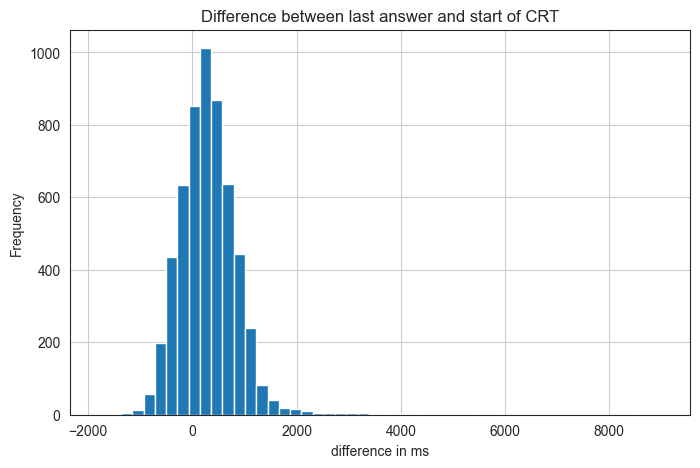

In [45]:
df_joined_sessionId_timers["time_elapsed_ms"] = (
    df_joined_sessionId_timers["start_time"]
    - df_joined_sessionId_timers["latest_createdAt"]
).dt.total_seconds() * 1000

df_filtered = df_joined_sessionId_timers[
    (df_joined_sessionId_timers["time_elapsed_ms"] >= -2000)
    & (df_joined_sessionId_timers["time_elapsed_ms"] <= 10000)
]

plt.figure(figsize=(8, 5))
df_filtered["time_elapsed_ms"].hist(bins=50)
plt.xlabel("difference in ms")
plt.ylabel("Frequency")
plt.title("Difference between last answer and start of CRT")
plt.show()

In [46]:
df_possible_matches = df_orphan.join(
    df_answer_15,
    left_on="start_time_rounded",
    right_on="latest_createdAt",
    how="inner",
)

df_possible_matches

userSessionId,CRT,rmeTen,demographics,demographicsLongInternational,CRT_right,rmeTen_right,demographics_right,demographicsLongInternational_right,crt_score,rmeTen_score,birth_year,gender,marital_status,language_primary,english_written,english_spoken,employment_status,country_reside,education_US,latin_US,race_US,income_US,CRT_right_parsed,secondsElapsed,start_time,start_time_rounded,sessionId,num_answers
str,str,str,str,str,str,str,str,str,f64,f64,str,str,str,str,i64,i64,str,str,str,str,list[str],str,datetime[μs],f32,datetime[ms],datetime[μs],str,u32
"""Wjnp2MqDSWpR03ZKOqr6P-c4dpV0cl…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-06-12 05:38:28""","""2024-06-12 05:40:31""","""2024-06-12 05:41:13""",null,0.0,6.0,"""1990""","""male""","""Married or Domestic Partnershi…","""Hindi""",5,3,"""Self-employed""","""India""",null,null,[],null,2024-06-12 05:38:28,299.742004,2024-06-12 05:33:28.258,2024-06-12 05:33:28,"""9KvtmL02Lk1tm4RfdZoY_ZhAG41lsH…",15
"""ou8Jhm-v9vA6nXo01eaLWfhOQPpaDZ…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-06-12 11:37:55""","""2024-06-12 11:39:32""","""2024-06-12 11:40:11""",null,0.0,4.0,"""1966""","""male""","""Single Never Married""","""English""",5,5,"""Employed for wages""","""India""",null,null,[],null,2024-06-12 11:37:55,134.386993,2024-06-12 11:35:40.613,2024-06-12 11:35:41,"""Prt54z46eE3sCRgKRIn0_bQ9yeapkY…",15
"""htbaldHAHnJYbtnSrDLaCPyCMAQCcr…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-06-17 08:27:13""","""2024-06-17 08:29:23""","""2024-06-17 08:30:36""",null,5.0,6.0,"""1993""","""male""","""Married or Domestic Partnershi…","""English""",5,5,"""Self-employed""","""United States""","""6""","""No""","[""White""]","""$10,000-$19,999""",2024-06-17 08:27:13,916.80603,2024-06-17 08:11:56.194,2024-06-17 08:11:56,"""j83oA4arrNE7xJ3k0FwpGwVKODWSvD…",15
"""oCUaKJtMlYj5febbFt8kD_z0j-FK0y…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-06-19 03:04:57""","""2024-06-19 03:06:08""","""2024-06-19 03:06:52""",null,5.0,9.0,"""1981""","""female""","""Married or Domestic Partnershi…","""English""",5,5,"""Employed for wages""","""United States""","""6""","""No""","[""White"", ""Asian""]","""$50,000-$74,999""",2024-06-19 03:04:57,444.92099,2024-06-19 02:57:32.079,2024-06-19 02:57:32,"""XTyiQdxz-eYE_Bl7MME2jL1GZhSrri…",15
"""Wvesp4iHPkWb4m-ITT8qprklI0BbcF…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-06-19 03:55:54""","""2024-06-19 03:56:44""","""2024-06-19 03:57:09""",null,6.0,9.0,"""1994""","""female""","""Single Never Married""","""English""",5,5,"""Employed for wages""","""United States""","""8""","""No""","[""White""]","""$100,000-$149,999""",2024-06-19 03:55:54,182.830002,2024-06-19 03:52:51.170,2024-06-19 03:52:51,"""nZrVHSyMGUBQEqFw8mFokPapoG3h7l…",15
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""fEmwzugltwymRlvglSDgqF6CGIDxWU…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-06-24 03:00:30""","""2024-06-24 03:01:17""","""2024-06-24 03:02:12""",null,2.0,8.0,"""1987""","""male""","""Married or Domestic Partnershi…","""English""",5,5,"""Employed for wages""","""United States""","""6""","""No""","[""White""]","""$100,000-$149,999""",2024-06-24 03:00:30,52.027,2024-06-24 02:59:37.973,2024-06-24 02:59:38,"""7Ql0mHSeLK4gpWN7Gfhe12nnjBLxS8…",15
"""Bq3QSsMKcVlwCpSTgW2pi57Clm9CUm…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-06-24 11:36:14""","""2024-06-24 11:41:20""","""2024-06-24 11:42:46""",null,3.0,7.0,"""1980""","""male

In [47]:
df_orphan.filter(pl.col("start_time") == pl.datetime(2024, 10, 7, 14, 7, 44))

userSessionId,CRT,rmeTen,demographics,demographicsLongInternational,CRT_right,rmeTen_right,demographics_right,demographicsLongInternational_right,crt_score,rmeTen_score,birth_year,gender,marital_status,language_primary,english_written,english_spoken,employment_status,country_reside,education_US,latin_US,race_US,income_US,CRT_right_parsed,secondsElapsed,start_time,start_time_rounded
str,str,str,str,str,str,str,str,str,f64,f64,str,str,str,str,i64,i64,str,str,str,str,list[str],str,datetime[μs],f32,datetime[ms],datetime[μs]


In [48]:
df_answer_15.filter(pl.col("sessionId") == "kN51XnkgRm9Fexer5FQv3b0NdNqiRbmc")

sessionId,num_answers,latest_createdAt
str,u32,datetime[μs]
"""kN51XnkgRm9Fexer5FQv3b0NdNqiRb…",15,2024-10-07 14:07:44


In [49]:
df_commonsense_country_info = df_with_crt.join(
    df_session, left_on="userSessionId", right_on="sessionId", how='inner'
)
print(df_commonsense_country_info.shape)
df_commonsense_country_info

(6125, 30)


userSessionId,CRT,rmeTen,demographics,demographicsLongInternational,CRT_right,rmeTen_right,demographics_right,demographicsLongInternational_right,crt_score,rmeTen_score,birth_year,gender,marital_status,language_primary,english_written,english_spoken,employment_status,country_reside,education_US,latin_US,race_US,income_US,CRT_right_parsed,secondsElapsed,start_time,consensus,awareness,response_count,commonsensicality
str,str,str,str,str,str,str,str,str,f64,f64,str,str,str,str,i64,i64,str,str,str,str,list[str],str,datetime[μs],f32,datetime[ms],f64,f64,u32,f64
"""O7RgVQNbJPrI1emJOP833bguHvr6l9…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-10-10 14:06:05""","""2024-10-10 14:07:18""","""2024-10-10 14:08:15""",null,2.0,9.0,"""1998""","""female""","""Single Never Married""","""English""",5,5,"""Out of work and looking for wo…","""United Kingdom""",null,null,[],null,2024-10-10 14:06:05,426.372986,2024-10-10 13:58:58.627,0.8,0.8,15,0.8
"""wf1XzBTC2rh2QcAueZ_qW8ZGtIpwQL…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-06-25 14:53:08""","""2024-06-25 14:55:03""","""2024-06-25 14:55:46""",null,2.0,6.0,"""1982""","""male""","""Single Never Married""","""Hindi""",5,4,null,"""India""",null,null,[],null,2024-06-25 14:53:08,122.608002,2024-06-25 14:51:05.392,0.533333,0.666667,15,0.596285
"""vDXCS68PNFi3xsv-osCHESn9_tBjaG…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-06-19 13:38:56""","""2024-06-19 13:40:59""","""2024-06-19 13:42:04""",null,2.0,9.0,"""1961""","""female""","""Divorced""","""English""",5,5,"""Employed for wages""","""United States""","""6""","""No""","[""White""]","""$100,000-$149,999""",2024-06-19 13:38:56,71.353996,2024-06-19 13:37:44.646,0.933333,1.0,15,0.966092
"""lu5J-fH9iQErNT447lvMJabgeu34Cj…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-10-07 20:49:21""","""2024-10-07 20:50:57""","""2024-10-07 20:51:49""",null,4.0,8.0,"""1985""","""female""","""Other""","""English""",5,5,"""Employed for wages""","""United Kingdom""",null,null,[],null,2024-10-07 20:49:21,275.704987,2024-10-07 20:44:45.295,0.866667,0.733333,15,0.797217
"""z5pCi8JM01oB3GOePkfqhmt5-DBOfx…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-10-07 04:04:55""","""2024-10-07 04:06:48""","""2024-10-07 04:07:36""",null,4.0,9.0,"""1997""","""other""","""Single Never Married""","""English""",5,5,"""Employed for wages""","""United States""","""6""","""No""","[""Asian""]","""$150,000 or more""",2024-10-07 04:04:55,355.471008,2024-10-07 03:58:59.529,0.666667,0.466667,15,0.557773
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""15XyjwAr9ZWIRxpd34kudzZNa7xEYc…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-10-06 17:04:13""","""2024-10-06 17:06:14""","""2024-10-06 17:06:53""",null,5.0,10.0,"""1986""","""male""","""Married or Domestic Partnershi…","""English""",5,5,"""Employed for wages""","""Denmark""",null,null,[],null,2024-10-06 17:04:13,155.923996,2024-10-06 17:01:37.076,0.866667,0.866667,15,0.866667
"""AQK7E_P6aQqn7RzCspxK4Ysmwce21t…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-10-08 19:33:54""","""2024-10-08 19:35:53""","""2024-10-08 19:36:55""",null,5.0,6.0,"""1962""","""female""",null,"""English""",5,5,"""Employed for wages""","""United Kingdom""",null,null,[],null,2024-10-08 19:33:54,654.961975,2024-10-08 19:22:59.038,0.733333,0.666667,15,0.699206
"""e4TY5sCp8EbrUVZGRry4Z6EREba5fI…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySou

In [50]:
df_with_crt

userSessionId,CRT,rmeTen,demographics,demographicsLongInternational,CRT_right,rmeTen_right,demographics_right,demographicsLongInternational_right,crt_score,rmeTen_score,birth_year,gender,marital_status,language_primary,english_written,english_spoken,employment_status,country_reside,education_US,latin_US,race_US,income_US,CRT_right_parsed,secondsElapsed,start_time
str,str,str,str,str,str,str,str,str,f64,f64,str,str,str,str,i64,i64,str,str,str,str,list[str],str,datetime[μs],f32,datetime[ms]
"""FkNLAgvZVY9w_7ZdMSlLg7FGlbuttt…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-04-23 17:48:36""","""2024-04-23 17:49:01""","""2024-04-23 17:49:41""",null,0.0,4.0,"""1999""","""female""","""Married or Domestic Partnershi…","""English""",5,5,"""Employed for wages""","""United States""","""7""","""No""","[""White""]","""$100,000-$149,999""",2024-04-23 17:48:36,16.542,2024-04-23 17:48:19.458
"""l4JyCjo2Mq0huM9-Z78JRvxO3bERBK…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-05-29 17:56:59""","""2024-05-29 17:57:14""","""2024-05-29 17:57:18""",null,0.0,4.0,"""2000""","""female""","""Widowed""","""Arabic""",1,5,"""Unable to work""","""Bahamas""",null,null,[],null,2024-05-29 17:56:59,1462.202026,2024-05-29 17:32:36.798
"""ZT_ckkMnCIWKaeFQtEjEdiIpFjx2xk…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-05-31 16:27:30""","""2024-05-31 16:28:06""","""2024-05-31 16:29:07""",null,0.0,3.0,"""1985""","""male""","""Married or Domestic Partnershi…","""Korean""",5,5,"""Out of work and looking for wo…","""United States""","""4""","""Yes""","[""Asian"", ""White""]","""$30,000-$39,999""",2024-05-31 16:27:30,11.385,2024-05-31 16:27:18.615
"""VPgzPGNjKA4_OQ5VJvvEKyeoAe2DpZ…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-05-31 16:58:16""","""2024-05-31 16:58:25""","""2024-05-31 16:58:36""",null,0.0,4.0,"""2000""","""female""","""Widowed""","""Arabic""",1,5,"""Unable to work""","""Bahamas""",null,null,[],null,2024-05-31 16:58:16,1483.790039,2024-05-31 16:33:32.210
"""wx2DpRTkgySjtK2a8sgKVRHV_hi-F7…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-06-06 16:50:40""","""2024-06-06 16:51:13""","""2024-06-06 16:52:13""",null,0.0,8.0,"""1961""","""female""","""Divorced""","""English""",5,5,"""Employed for wages""","""United States""","""5""","""No""","[""White""]","""$50,000-$74,999""",2024-06-06 16:50:40,58.095001,2024-06-06 16:49:41.905
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""iyE8Q-Hq54GCMtOYlzBvUHfEAq_Oyr…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2025-01-14 21:59:50""","""2025-01-14 22:01:16""","""2025-01-14 22:01:55""",null,4.0,8.0,"""1982""","""male""","""Married or Domestic Partnershi…","""English""",5,5,"""Employed for wages""","""United States""","""8""","""No""","[""White""]","""$100,000-$149,999""",2025-01-14 21:59:50,115.124001,2025-01-14 21:57:54.876
"""NvsQs6nVeQJQ42gDnTQnuWiJUVoRPs…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2025-01-15 01:06:37""","""2025-01-15 01:07:59""","""2025-01-15 01:08:57""",null,0.0,7.0,"""1960""","""female""","""Married or Domestic Partnershi…","""English""",5,5,"""Employed for wages""","""United States""","""4""","""No""","[""White""]","""$75,000-$99,999""",2025-01-15 01:06:37,259.226013,2025-01-15 01:02:17.774
"""COQN5Y4-ppLuwdccoKWRqPFs6de7Yr…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2025-01-15 01:21:04""","""2025-01-15 01:44:13""","""2025-01-15 01:46:13""",

In [51]:
df_answers

id,I_agree,I_agree_reason,others_agree,others_agree_reason,perceived_commonsense,clarity,origLanguage,sessionId,createdAt,updatedAt,statement_number,statementId,clientVersion
i64,f64,str,f64,str,i64,str,str,str,str,str,i64,i64,str
1,1.0,"""It's obvious""",1.0,"""I think most people have good …",1,"""Clear: it is clearly written a…","""en""","""uZBSJf5x8X7I1vvwiX4K7YfrB7hY_t…","""2023-06-14 17:11:11""","""2023-06-14 17:11:11""",6,6,null
2,1.0,"""It's something I learned""",1.0,"""I think most people have good …",1,"""Clear: it is clearly written a…","""en""","""siFSQa8F_h3woRq5maLEsmoDQmA-ws…","""2023-06-14 17:11:17""","""2023-06-14 17:11:17""",6,6,null
3,1.0,"""It's something I learned""",1.0,"""I think most people have good …",1,"""Clear: it is clearly written a…","""en""","""7A2Xy3lMfn_Pe12DeucuE-1swxAv34…","""2023-06-14 17:11:23""","""2023-06-14 17:11:23""",6,6,null
4,1.0,"""It's obvious""",1.0,"""I think most people lack good …",0,"""Clear: it is clearly written a…","""en""","""n4yeiqY8p1DDUmxhKphavobA-w5LCn…","""2023-06-14 17:11:27""","""2023-06-14 17:11:27""",149,149,null
5,0.0,"""I don't know""",0.0,"""I don't know""",0,"""Confusing: I don't quite under…","""en""","""uZBSJf5x8X7I1vvwiX4K7YfrB7hY_t…","""2023-06-14 17:11:34""","""2023-06-14 17:11:34""",149,149,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…
793038,1.0,"""It's my opinion""",1.0,"""I think most people have good …",1,null,"""en""","""r5P3karHQRT9a9fPQei8cXU1UijCCZ…","""2025-04-02 14:52:09""","""2025-04-02 14:52:09""",9366,9366,"""bbcd5d5"""
793039,1.0,"""It's obvious""",1.0,"""I think it's mostly a matter o…",1,null,"""en""","""r5P3karHQRT9a9fPQei8cXU1UijCCZ…","""2025-04-02 14:52:39""","""2025-04-02 14:52:39""",9525,9525,"""bbcd5d5"""
793040,1.0,"""It's obvious""",1.0,"""I think most people have good …",1,null,"""en""","""r5P3karHQRT9a9fPQei8cXU1UijCCZ…","""2025-04-02 14:53:14""","""2025-04-02 14:53:14""",9941,9941,"""bbcd5d5"""


In [52]:
df_country_plot = df_commonsense_country_info.group_by("country_reside").agg(
    pl.col("commonsensicality").mean().alias("avg_commonsensicality")
)

In [53]:
df_replaced.join(
    df_commonsense_country_info,
    right_on="userSessionId",
    left_on="sessionId",
    how="left",
).filter(pl.col("country_reside").is_not_null())
# .group_by("country_reside").agg(
#     pl.col("commonsensicality").mean().alias("avg_commonsensicality"),
#     pl.col("sessionId").count().alias("count")
# )

id,I_agree,I_agree_reason,others_agree,others_agree_reason,perceived_commonsense,clarity,origLanguage,sessionId,createdAt,updatedAt,statement_number,statementId,clientVersion,median_I_agree,is_consensus,is_aware,behavior,everyday,figure_of_speech,judgment,opinion,reasoning,CRT,rmeTen,demographics,demographicsLongInternational,CRT_right,rmeTen_right,demographics_right,demographicsLongInternational_right,crt_score,rmeTen_score,birth_year,gender,marital_status,language_primary,english_written,english_spoken,employment_status,country_reside,education_US,latin_US,race_US,income_US,CRT_right_parsed,secondsElapsed,start_time,consensus,awareness,response_count,commonsensicality
i64,f64,str,f64,str,i64,str,str,str,datetime[μs],str,i64,i64,str,f64,f64,f64,i64,i64,i64,i64,i64,i64,str,str,str,str,str,str,str,str,f64,f64,str,str,str,str,i64,i64,str,str,str,str,list[str],str,datetime[μs],f32,datetime[ms],f64,f64,u32,f64
3376,1.0,"""It's obvious""",1.0,"""I think most people have good …",1,null,"""en""","""nT7bs-XHJvtATColxhCUmKidpQZk0U…",2023-07-18 09:33:03,"""2023-07-18 09:33:03""",1653,1653,null,1.0,1.0,1.0,1,1,1,0,0,0,"""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-11-09 13:35:13""","""2024-11-09 13:35:35""","""2024-11-09 13:35:49""",null,0.0,2.0,"""1990""","""female""","""Married or Domestic Partnershi…","""Gujarathi""",1,1,"""Self-employed""","""Belgium""",null,null,[],null,2024-11-09 13:35:13,5.486,2024-11-09 13:35:07.514,0.8,0.814286,70,0.807111
3377,1.0,"""It's obvious""",1.0,"""I think most people have good …",1,null,"""en""","""nT7bs-XHJvtATColxhCUmKidpQZk0U…",2023-07-18 09:33:11,"""2023-07-18 09:33:11""",806,806,null,1.0,1.0,1.0,1,1,0,1,0,1,"""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-11-09 13:35:13""","""2024-11-09 13:35:35""","""2024-11-09 13:35:49""",null,0.0,2.0,"""1990""","""female""","""Married or Domestic Partnershi…","""Gujarathi""",1,1,"""Self-employed""","""Belgium""",null,null,[],null,2024-11-09 13:35:13,5.486,2024-11-09 13:35:07.514,0.8,0.814286,70,0.807111
3378,1.0,"""It's obvious""",1.0,"""I don't know""",0,null,"""en""","""nT7bs-XHJvtATColxhCUmKidpQZk0U…",2023-07-18 09:33:50,"""2023-07-18 09:33:50""",4161,4161,null,1.0,1.0,1.0,1,1,0,0,1,1,"""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-11-09 13:35:13""","""2024-11-09 13:35:35""","""2024-11-09 13:35:49""",null,0.0,2.0,"""1990""","""female""","""Married or Domestic Partnershi…","""Gujarathi""",1,1,"""Self-employed""","""Belgium""",null,null,[],null,2024-11-09 13:35:13,5.486,2024-11-09 13:35:07.514,0.8,0.814286,70,0.807111
3379,1.0,"""It's obvious""",1.0,"""I think most people have good …",0,null,"""en""","""nT7bs-XHJvtATColxhCUmKidpQZk0U…",2023-07-18 09:33:55,"""2023-07-18 09:33:55""",831,831,null,1.0,1.0,1.0,0,1,0,0,0,1,"""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-11-09 13:35:13""","""2024-11-09 13:35:35""","""2024-11-09 13:35:49""",null,0.0,2.0,"""1990""","""female""","""Married or Domestic Partnershi…","""Gujarathi""",1,1,"""Self-employed""","""Belgium""",null,null,[],null,2024-11-09 13:35:13,5.486,2024-11-09 13:35:07.514,0.8,0.814286,70,0.807111
3380,1.0,"""It's obvious""",1.0,"""I think most people have good …",1,null,"""en""","""nT7bs-XHJvtATColxhCUmKidpQZk0U…",2023-07-18 09:34:42,"""2023-07-18 09:34:42""",3794,3794,null,0.0,0.0,0.0,0,1,0,0,0,1,"""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-11-09 13:35:13""","""2024-11-09 13:35:35""","""2024-11-09 13:35:49""",null,0.0,2.0,"""1990""","""female""","""Married or Domestic Partnershi…","""Gujarathi""",1,1,"""Self-employed""","""Belgium""",null,null,[],null,2024-11-09 13:35:13,5.486,2024-11-09 13:35:07.514,0

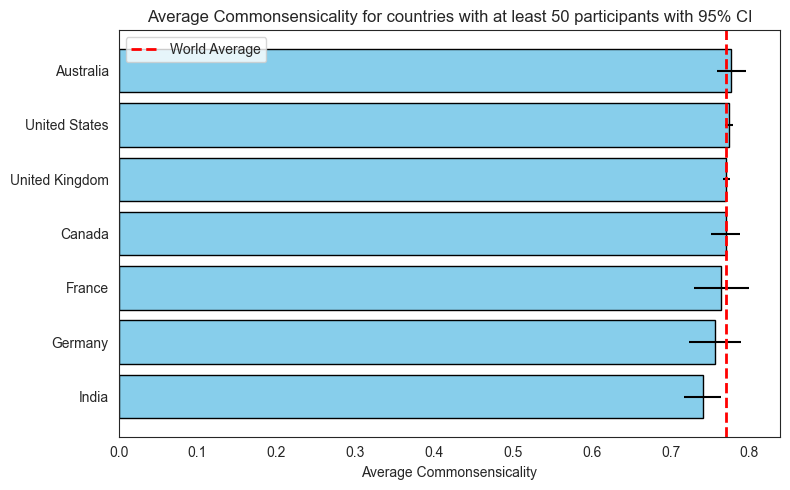

In [54]:
pandas_df_commonsense_country_info = df_commonsense_country_info.to_pandas()

world_avg = df_commonsense_country_info["commonsensicality"].mean()

grouped = (
    pandas_df_commonsense_country_info.groupby("country_reside")["commonsensicality"]
    .agg(["mean", "std", "count"])
    .reset_index()
)
grouped.rename(columns={"mean": "avg_commonsensicality"}, inplace=True)

# remove countries with less than 2 participants
grouped = grouped[grouped["count"] >= 50]

grouped["ci"] = 1.96 * grouped["std"] / np.sqrt(grouped["count"])

grouped_sorted = grouped.sort_values("avg_commonsensicality", ascending=True)

plt.figure(figsize=(8, 5))
plt.barh(
    grouped_sorted["country_reside"],
    grouped_sorted["avg_commonsensicality"],
    xerr=grouped_sorted["ci"],
    color="skyblue",
    edgecolor="black",
)

plt.axvline(
    x=world_avg, color="red", linestyle="--", linewidth=2, label="World Average"
)

plt.xlabel("Average Commonsensicality")
plt.title("Average Commonsensicality for countries with at least 50 participants with 95% CI")
plt.legend()
plt.tight_layout()
plt.savefig("figures/average_commonsensicality_by_country.pdf", dpi=300, bbox_inches="tight")

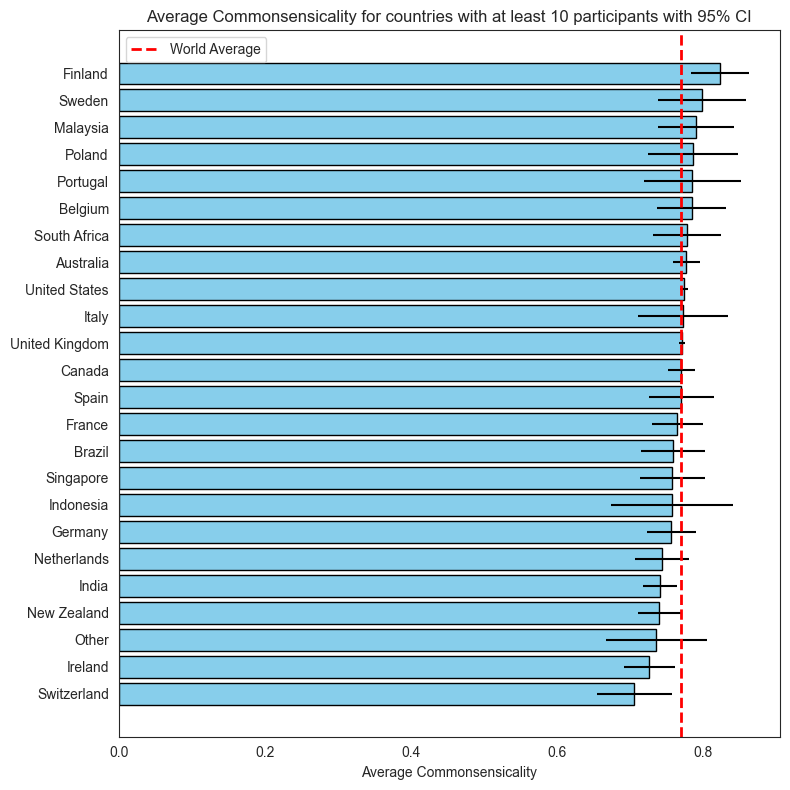

In [55]:
pandas_df_commonsense_country_info = df_commonsense_country_info.to_pandas()

world_avg = df_commonsense_country_info["commonsensicality"].mean()

grouped = (
    pandas_df_commonsense_country_info.groupby("country_reside")["commonsensicality"]
    .agg(["mean", "std", "count"])
    .reset_index()
)
grouped.rename(columns={"mean": "avg_commonsensicality"}, inplace=True)

# remove countries with less than 2 participants
grouped = grouped[grouped["count"] >= 10]

grouped["ci"] = 1.96 * grouped["std"] / np.sqrt(grouped["count"])

grouped_sorted = grouped.sort_values("avg_commonsensicality", ascending=True)

plt.figure(figsize=(8, 8))
plt.barh(
    grouped_sorted["country_reside"],
    grouped_sorted["avg_commonsensicality"],
    xerr=grouped_sorted["ci"],
    color="skyblue",
    edgecolor="black",
)

plt.axvline(
    x=world_avg, color="red", linestyle="--", linewidth=2, label="World Average"
)

plt.xlabel("Average Commonsensicality")
plt.title("Average Commonsensicality for countries with at least 10 participants with 95% CI")
plt.legend()
plt.tight_layout()
plt.savefig("figures/average_commonsensicality_by_country.pdf", dpi=300, bbox_inches="tight")

Bootstrap 50 people from each country with replacement 100 times 

distribution plot of commonsensicality by country



In [56]:
df = df_commonsense_country_info.to_pandas()

United Kingdom
United States
Australia
Canada
India


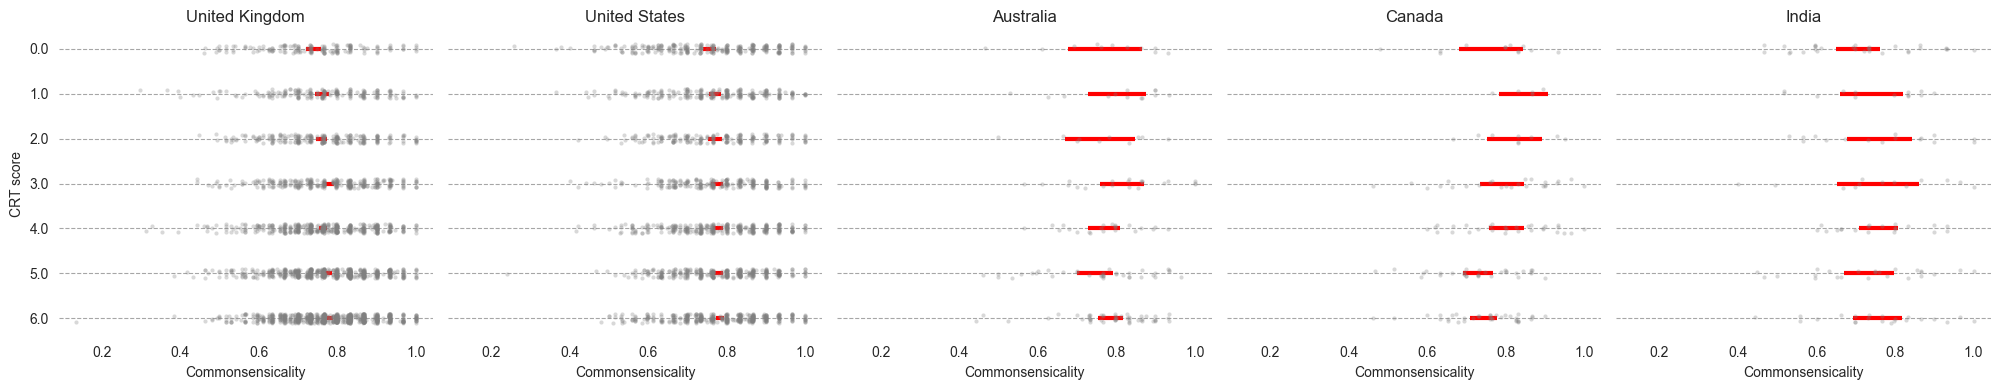

In [57]:
country_counts = df["country_reside"].value_counts()
valid_countries = country_counts[country_counts > 60].index.tolist()

df_filtered = df[df["country_reside"].isin(valid_countries)]


g = sns.FacetGrid(
    df_filtered,
    col="country_reside",
    col_wrap=6,
    sharex=True,
    sharey=True,
    height=4,
    col_order=valid_countries,
)


g.map_dataframe(
    sns.stripplot,
    x="commonsensicality",
    y="crt_score",
    color="gray",
    alpha=0.3,
    size=3,
    orient="h",
)

g.set_axis_labels("Commonsensicality", "CRT score")


for ax in g.axes.flat:

    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.grid(axis="y", linestyle="--", color="gray", alpha=0.7)

    title = ax.get_title()
    if "=" in title:
        country = title.split(" = ")[-1].strip()
    else:
        country = title

    print(country)
    ax.set_title(country)

    sub_df = df_filtered[df_filtered["country_reside"] == country]

    stats_df = (
        sub_df.groupby("crt_score")["commonsensicality"]
        .agg(["mean", "std", "count"])
        .reset_index()
    )

    stats_df["sem"] = stats_df["std"] / np.sqrt(stats_df["count"])
    stats_df["ci"] = stats_df.apply(
        lambda row: (
            row["sem"] * stats.t.ppf((1 + 0.95) / 2.0, row["count"] - 1)
            if row["count"] > 1
            else 0
        ),
        axis=1,
    )

    ax.hlines(
        y=stats_df["crt_score"],
        xmin=stats_df["mean"] - stats_df["ci"],
        xmax=stats_df["mean"] + stats_df["ci"],
        colors="red",
        linestyles="solid",
        linewidth=3,
    )

plt.tight_layout()
plt.show()

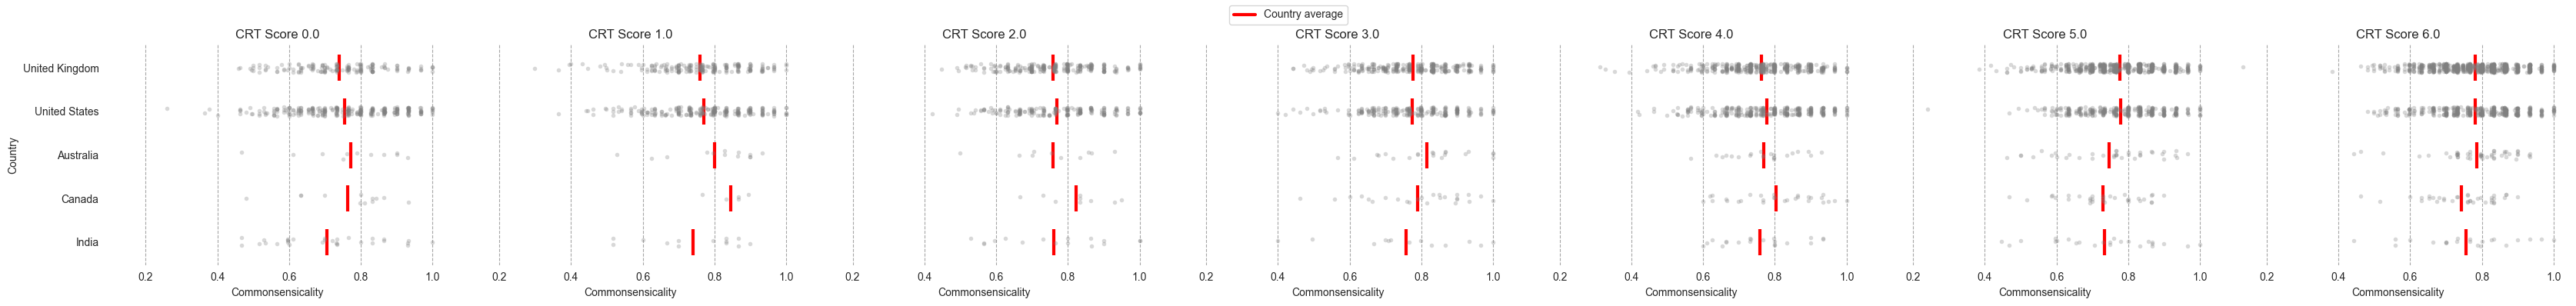

In [58]:
from matplotlib.lines import Line2D


country_counts = df["country_reside"].value_counts()
valid_countries = country_counts[country_counts > 60].index.tolist()
df_filtered = df[df["country_reside"].isin(valid_countries)]
df_filtered = df_filtered.dropna(subset=["crt_score"])


sorted_crt = sorted(df_filtered["crt_score"].unique())


overall_common = df_filtered["commonsensicality"].mean()


g = sns.FacetGrid(
    df_filtered,
    col="crt_score",
    col_order=sorted_crt,
    sharex=True,
    sharey=True,
    height=4,
    aspect=1.2,
)


g.map_dataframe(
    sns.stripplot,
    x="commonsensicality",
    y="country_reside",
    order=valid_countries,
    color="gray",
    alpha=0.3,
    size=4,
    orient="h",
)

g.set_axis_labels("Commonsensicality", "Country")


for ax in g.axes.flat:

    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.grid(axis="x", linestyle="--", color="gray", alpha=0.7)

    title = ax.get_title()
    if "=" in title:
        crt_val = title.split("=")[-1].strip()
    else:
        crt_val = title
    ax.set_title(f"CRT Score {crt_val}")

    sub_df = df_filtered[df_filtered["crt_score"] == float(crt_val)]

    stats_df = (
        sub_df.groupby("country_reside")["commonsensicality"].mean().reset_index()
    )

    for _, row in stats_df.iterrows():
        country = row["country_reside"]
        mean_val = row["commonsensicality"]
        if country in valid_countries:
            y_pos = valid_countries.index(country)

            delta = 0.3
            ax.vlines(
                x=mean_val,
                ymin=y_pos - delta,
                ymax=y_pos + delta,
                colors="red",
                linewidth=3,
            )


legend_handles = [
    Line2D([], [], color="red", linestyle="-", linewidth=3, label="Country average")
]
plt.figlegend(handles=legend_handles, loc="upper center", ncol=1, frameon=True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(
    "figures/average_commonsensicality_by_country_crt.pdf", dpi=300, bbox_inches="tight"
)

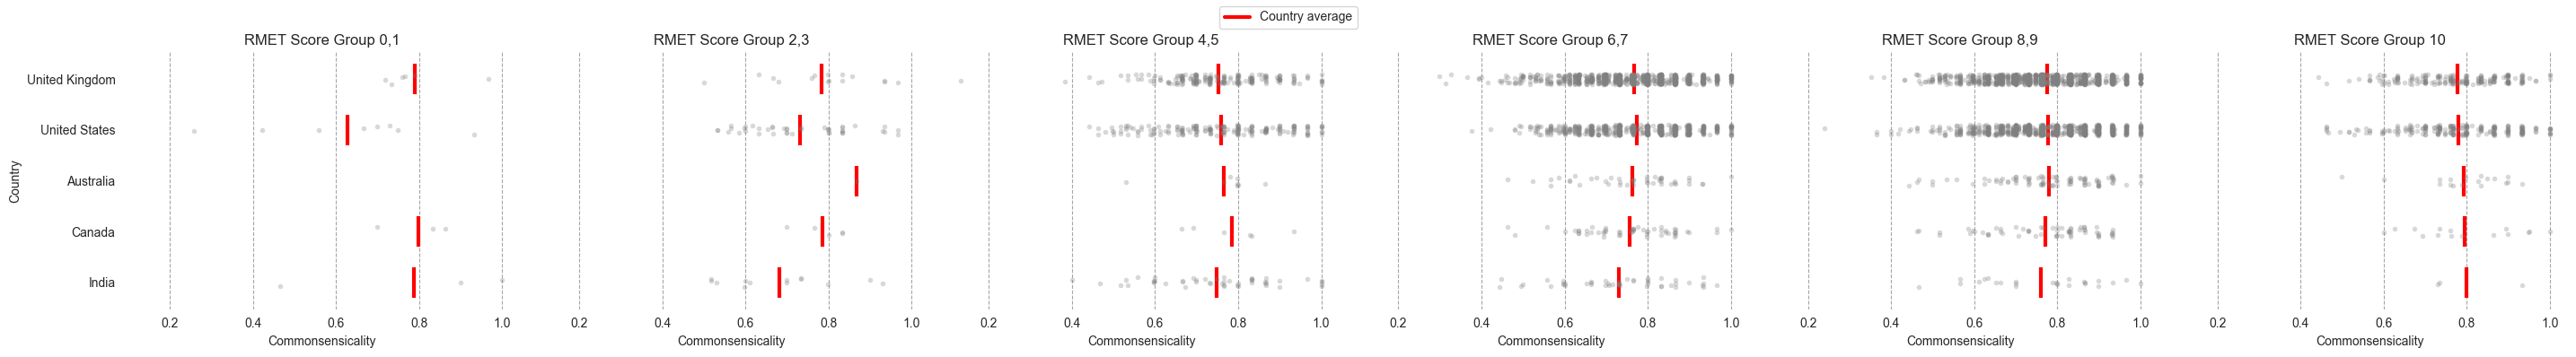

In [59]:
country_counts = df["country_reside"].value_counts()
valid_countries = country_counts[country_counts > 60].index.tolist()
df_filtered = df[df["country_reside"].isin(valid_countries)]
df_filtered = df_filtered.dropna(subset=["rmeTen_score"])

bins = [-0.5, 1.5, 3.5, 5.5, 7.5, 9.5, 10.5]
labels = ["0,1", "2,3", "4,5", "6,7", "8,9", "10"]
df_filtered["rmet_group"] = pd.cut(
    df_filtered["rmeTen_score"], bins=bins, labels=labels, include_lowest=True
)


sorted_rmet = labels


g = sns.FacetGrid(
    df_filtered,
    col="rmet_group",
    col_order=sorted_rmet,
    sharex=True,
    sharey=True,
    height=4,
    aspect=1.2,
)


g.map_dataframe(
    sns.stripplot,
    x="commonsensicality",
    y="country_reside",
    order=valid_countries,
    color="gray",
    alpha=0.3,
    size=4,
    orient="h",
)

g.set_axis_labels("Commonsensicality", "Country")


for ax in g.axes.flat:

    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.grid(axis="x", linestyle="--", color="gray", alpha=0.7)

    title = ax.get_title()
    if "=" in title:
        group_val = title.split("=")[-1].strip()
    else:
        group_val = title
    ax.set_title(f"RMET Score Group {group_val}")

    sub_df = df_filtered[df_filtered["rmet_group"] == group_val]

    stats_df = (
        sub_df.groupby("country_reside")["commonsensicality"].mean().reset_index()
    )

    for _, row in stats_df.iterrows():
        country = row["country_reside"]
        mean_val = row["commonsensicality"]
        if country in valid_countries:
            y_pos = valid_countries.index(country)
            delta = 0.3
            ax.vlines(
                x=mean_val,
                ymin=y_pos - delta,
                ymax=y_pos + delta,
                colors="red",
                linewidth=3,
            )


legend_handles = [
    Line2D([], [], color="red", linestyle="-", linewidth=3, label="Country average")
]
plt.figlegend(handles=legend_handles, loc="upper center", ncol=1, frameon=True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(
    "figures/average_commonsensicality_by_country_rmet_group.pdf", dpi=300, bbox_inches="tight"
)
plt.show()

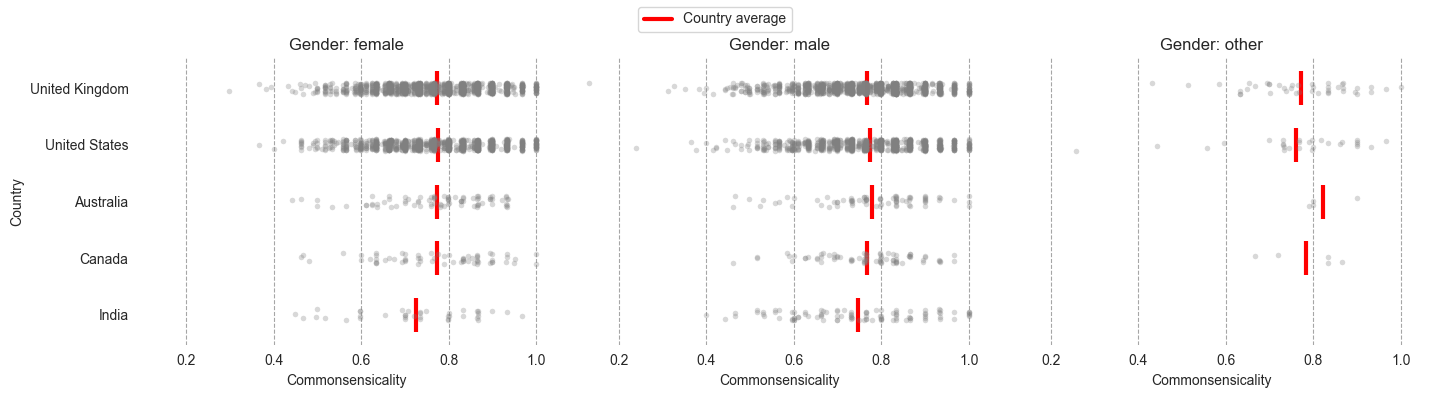

In [60]:
country_counts = df["country_reside"].value_counts()
valid_countries = country_counts[country_counts > 60].index.tolist()
df_filtered = df[df["country_reside"].isin(valid_countries)]
df_filtered = df_filtered.dropna(subset=["gender"])


sorted_gender = sorted(df_filtered["gender"].unique())


overall_common = df_filtered["commonsensicality"].mean()


g = sns.FacetGrid(
    df_filtered,
    col="gender",
    col_order=sorted_gender,
    sharex=True,
    sharey=True,
    height=4,
    aspect=1.2,
)


g.map_dataframe(
    sns.stripplot,
    x="commonsensicality",
    y="country_reside",
    order=valid_countries,
    color="gray",
    alpha=0.3,
    size=4,
    orient="h",
)

g.set_axis_labels("Commonsensicality", "Country")


for ax in g.axes.flat:

    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.grid(axis="x", linestyle="--", color="gray", alpha=0.7)

    title = ax.get_title()
    if "=" in title:
        gender_val = title.split("=")[-1].strip()
    else:
        gender_val = title
    ax.set_title(f"Gender: {gender_val}")

    sub_df = df_filtered[df_filtered["gender"] == gender_val]

    stats_df = (
        sub_df.groupby("country_reside")["commonsensicality"].mean().reset_index()
    )

    for _, row in stats_df.iterrows():
        country = row["country_reside"]
        mean_val = row["commonsensicality"]
        if country in valid_countries:

            y_pos = valid_countries.index(country)
            delta = 0.3
            ax.vlines(
                x=mean_val,
                ymin=y_pos - delta,
                ymax=y_pos + delta,
                colors="red",
                linewidth=3,
            )


legend_handles = [
    Line2D([], [], color="red", linestyle="-", linewidth=3, label="Country average")
]
plt.figlegend(handles=legend_handles, loc="upper center", ncol=1, frameon=True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(
    "figures/average_commonsensicality_by_country_gender.pdf", dpi=300, bbox_inches="tight"
)
plt.show()

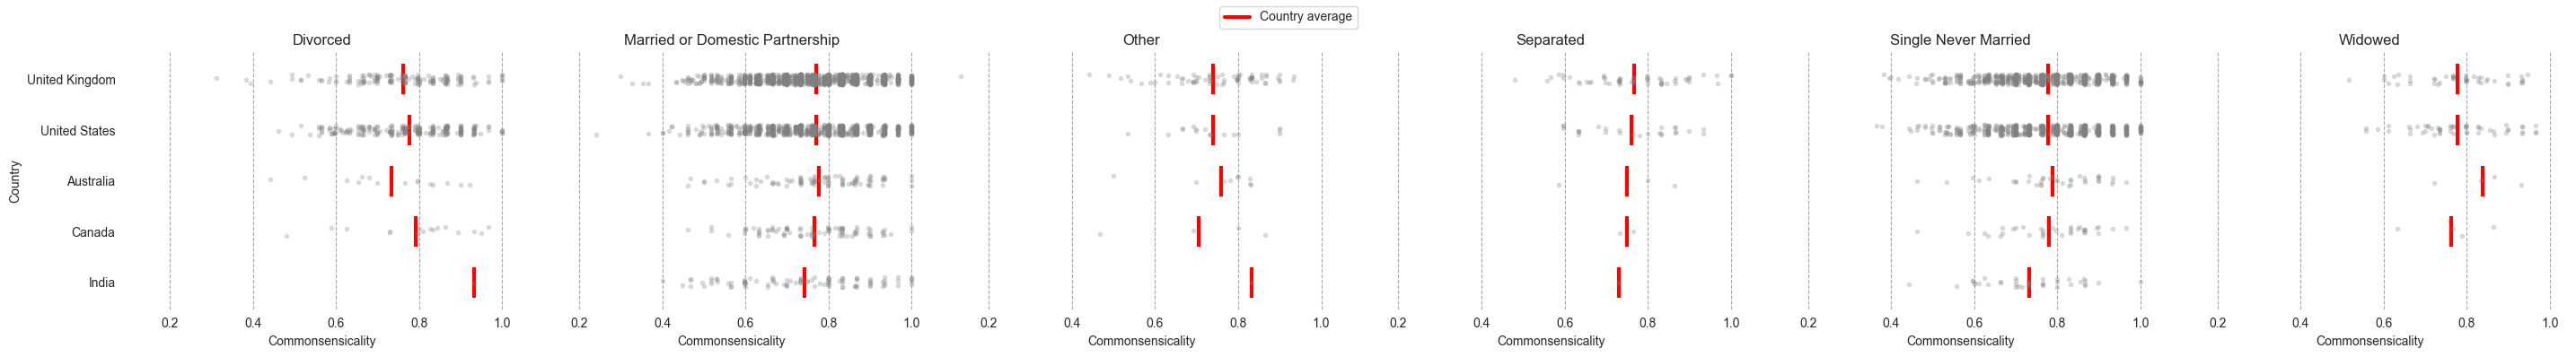

In [61]:
country_counts = df["country_reside"].value_counts()
valid_countries = country_counts[country_counts > 60].index.tolist()
df_filtered = df[df["country_reside"].isin(valid_countries)]
df_filtered = df_filtered.dropna(subset=["marital_status"])


sorted_marital_status = sorted(df_filtered["marital_status"].unique())


overall_common = df_filtered["commonsensicality"].mean()


g = sns.FacetGrid(
    df_filtered,
    col="marital_status",
    col_order=sorted_marital_status,
    sharex=True,
    sharey=True,
    height=4,
    aspect=1.2,
)


g.map_dataframe(
    sns.stripplot,
    x="commonsensicality",
    y="country_reside",
    order=valid_countries,
    color="gray",
    alpha=0.3,
    size=4,
    orient="h",
)

g.set_axis_labels("Commonsensicality", "Country")


for ax in g.axes.flat:

    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.grid(axis="x", linestyle="--", color="gray", alpha=0.7)

    title = ax.get_title()
    if "=" in title:
        marital_status_val = title.split("=")[-1].strip()
    else:
        marital_status_val = title
    ax.set_title(f"{marital_status_val}")

    sub_df = df_filtered[df_filtered["marital_status"] == marital_status_val]

    stats_df = (
        sub_df.groupby("country_reside")["commonsensicality"].mean().reset_index()
    )

    for _, row in stats_df.iterrows():
        country = row["country_reside"]
        mean_val = row["commonsensicality"]
        if country in valid_countries:

            y_pos = valid_countries.index(country)
            delta = 0.3
            ax.vlines(
                x=mean_val,
                ymin=y_pos - delta,
                ymax=y_pos + delta,
                colors="red",
                linewidth=3,
            )


legend_handles = [
    Line2D([], [], color="red", linestyle="-", linewidth=3, label="Country average")
]
plt.figlegend(handles=legend_handles, loc="upper center", ncol=1, frameon=True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(
    "figures/average_commonsensicality_by_country_marital_status.pdf",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

In [62]:
# predict commonsensicality based on country and other demographics

In [63]:
from scipy.stats import f_oneway

df_group = df_commonsense_country_info.to_pandas()
groups = [group["commonsensicality"].dropna() for name, group in df_group.groupby("country_reside")]

In [64]:
groups = [group for group in groups if len(group) > 10]

In [65]:
F, p_value = f_oneway(*groups)
print("ANOVA F-statistic:", F)
print("ANOVA p-value:", p_value)

ANOVA F-statistic: 1.5695505715771099
ANOVA p-value: 0.04378986707757049


In [66]:
df_commonsense_country_info.head(3)

userSessionId,CRT,rmeTen,demographics,demographicsLongInternational,CRT_right,rmeTen_right,demographics_right,demographicsLongInternational_right,crt_score,rmeTen_score,birth_year,gender,marital_status,language_primary,english_written,english_spoken,employment_status,country_reside,education_US,latin_US,race_US,income_US,CRT_right_parsed,secondsElapsed,start_time,consensus,awareness,response_count,commonsensicality
str,str,str,str,str,str,str,str,str,f64,f64,str,str,str,str,i64,i64,str,str,str,str,list[str],str,datetime[μs],f32,datetime[ms],f64,f64,u32,f64
"""O7RgVQNbJPrI1emJOP833bguHvr6l9…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-10-10 14:06:05""","""2024-10-10 14:07:18""","""2024-10-10 14:08:15""",null,2.0,9.0,"""1998""","""female""","""Single Never Married""","""English""",5,5,"""Out of work and looking for wo…","""United Kingdom""",null,null,[],null,2024-10-10 14:06:05,426.372986,2024-10-10 13:58:58.627,0.8,0.8,15,0.8
"""wf1XzBTC2rh2QcAueZ_qW8ZGtIpwQL…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-06-25 14:53:08""","""2024-06-25 14:55:03""","""2024-06-25 14:55:46""",null,2.0,6.0,"""1982""","""male""","""Single Never Married""","""Hindi""",5,4,null,"""India""",null,null,[],null,2024-06-25 14:53:08,122.608002,2024-06-25 14:51:05.392,0.533333,0.666667,15,0.596285
"""vDXCS68PNFi3xsv-osCHESn9_tBjaG…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-06-19 13:38:56""","""2024-06-19 13:40:59""","""2024-06-19 13:42:04""",null,2.0,9.0,"""1961""","""female""","""Divorced""","""English""",5,5,"""Employed for wages""","""United States""","""6""","""No""","[""White""]","""$100,000-$149,999""",2024-06-19 13:38:56,71.353996,2024-06-19 13:37:44.646,0.933333,1.0,15,0.966092


In [67]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_text
from sklearn.model_selection import train_test_split


df_pd = df_commonsense_country_info.to_pandas()

# Define the target and features.
target = "commonsensicality"
features = [
    "gender",
    "crt_score",
    "rmeTen_score",
    # "marital_status",
    # "language_primary",
    # "english_written",
    # "english_spoken",
    # "employment_status",
]

X = df_pd[features]
y = df_pd[target]


categorical_features = [
    "gender",
    # "marital_status",
    # "language_primary",
    # "employment_status",
]


X_encoded = pd.get_dummies(X, columns=categorical_features, drop_first=True)


X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)


reg_tree = DecisionTreeRegressor(random_state=42)
reg_tree.fit(X_train, y_train)


score = reg_tree.score(X_test, y_test)
print("R^2 Score on test data:", score)


tree_rules = export_text(reg_tree, feature_names=list(X_encoded.columns))
print("\nDecision Tree Rules:\n", tree_rules)

ModuleNotFoundError: No module named 'sklearn'

In [68]:
df_commonsense_country_info_columns = [
    "userSessionId",
    "crt_score",
    "rmeTen_score",
    "birth_year",
    "gender",
    "marital_status",
    "language_primary",
    "english_written",
    "english_spoken",
    "employment_status",
    "country_reside",
    "education_US",
    "latin_US",
    "race_US",
    "income_US",
    # "consensus",
    # "awareness",
    "commonsensicality",
]

df_answers_columns = [
    "I_agree",
    "others_agree",
    "perceived_commonsense",
    "sessionId",
    "statementId",
]

df_statements_columns = [
    "statementId",
    "behavior",
    "everyday",
    "figure_of_speech",
    "judgment",
    "opinion",
    "reasoning",
]

In [69]:
indiviudal_df_with_null_dropped = df_commonsense_country_info.filter(
    pl.col("crt_score").is_not_null() & pl.col("rmeTen_score").is_not_null()
)

Create group commonsensicality dataframe, each row is 1 answer to a statement but also includes the individual's demographic, crt score, rmet score and perosnal commonsensicality score (which repeats for multiple rows for that individial or sessionId obviously).


In [70]:
group_commonsensicality_df = (
    indiviudal_df_with_null_dropped[df_commonsense_country_info_columns]
    .join(
        df_answers[df_answers_columns],
        left_on="userSessionId",
        right_on="sessionId",
        how="left",
    )
    .join(
        statement_commonsensicality_with_properties[df_statements_columns],
        left_on="statementId",
        right_on="statementId",
        how="left",
    )
)

print(
    f"Number of rows in group_commonsensicality_df: {len(group_commonsensicality_df)}"
)
group_commonsensicality_df.head(3)

Number of rows in group_commonsensicality_df: 98472


userSessionId,crt_score,rmeTen_score,birth_year,gender,marital_status,language_primary,english_written,english_spoken,employment_status,country_reside,education_US,latin_US,race_US,income_US,commonsensicality,I_agree,others_agree,perceived_commonsense,statementId,behavior,everyday,figure_of_speech,judgment,opinion,reasoning
str,f64,f64,str,str,str,str,i64,i64,str,str,str,str,list[str],str,f64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64
"""O7RgVQNbJPrI1emJOP833bguHvr6l9…",2.0,9.0,"""1998""","""female""","""Single Never Married""","""English""",5,5,"""Out of work and looking for wo…","""United Kingdom""",null,null,[],null,0.8,1.0,1.0,1,9331,0,1,0,0,0,0
"""O7RgVQNbJPrI1emJOP833bguHvr6l9…",2.0,9.0,"""1998""","""female""","""Single Never Married""","""English""",5,5,"""Out of work and looking for wo…","""United Kingdom""",null,null,[],null,0.8,1.0,0.0,0,9224,0,1,0,0,0,0
"""O7RgVQNbJPrI1emJOP833bguHvr6l9…",2.0,9.0,"""1998""","""female""","""Single Never Married""","""English""",5,5,"""Out of work and looking for wo…","""United Kingdom""",null,null,[],null,0.8,0.0,1.0,0,9541,0,0,0,0,1,0


In [71]:
group_commonsensicality_df.group_by("crt_score").agg(pl.len().alias("count")).sort(
    "crt_score"
)

crt_score,count
f64,u32
0.0,8958
1.0,8117
2.0,8712
3.0,10954
4.0,16001
5.0,19376
6.0,26354


In [181]:
def do_corrolations_grouped(data_frame: pl.DataFrame, first_group, second_group):
    test_df = (
        data_frame.with_columns(
            [
                pl.when(
                    pl.col("I_agree")
                    .median()
                    .over(["statementId", first_group, second_group])
                    == 0.5
                )
                .then(pl.lit(1))
                .otherwise(
                    pl.col("I_agree")
                    .median()
                    .over(["statementId", first_group, second_group])
                )
                .alias("we_think"),
                pl.col("I_agree")
                .mean()
                .over(["statementId", first_group, second_group])
                .alias("continous_we_think"),
            ]
        )
        .group_by(["statementId", first_group, second_group])
        .agg(
            [
                # Consensus = (0.25 - mean(I_agree)*(1 - mean(I_agree))) * 4
                (
                    (0.25 - pl.col("I_agree").mean() * (1 - pl.col("I_agree").mean()))
                    * 4
                ).alias("consensus"),
                # awareness = mean(we_think == others_agree)
                pl.col("we_think").eq(pl.col("others_agree")).mean().alias("awareness"),
                # continous_awareness = mean(1 - abs(continous_we_think - others_agree))
                (1 - (pl.col("continous_we_think") - pl.col("others_agree")).abs())
                .mean()
                .alias("continous_awareness"),
                # n = count()
                pl.len().alias("number_of_answers"),
            ]
        )
        .with_columns(
            pl.when(pl.lit(True))
            .then((pl.col("consensus") * pl.col("continous_awareness")).sqrt())
            .otherwise((pl.col("consensus") * pl.col("awareness")).sqrt())
            .alias("commonsensicality")
        )
    )

    emtehan = test_df["statementId", first_group, second_group, "commonsensicality"]

    emtehan = emtehan.with_columns(
        (pl.col(first_group) + "_" + pl.col(second_group).cast(pl.Utf8)).alias(
            f"{first_group}_{second_group}"
        )
    )

    shared_name = f"{first_group}_{second_group}"

    # unique_first_group = data_frame[first_group].unique().to_series().to_list()
    # unique_second_group = data_frame[second_group].unique().to_series().to_list()

    two_group_df_corr_agg = (
        emtehan["statementId", shared_name, "commonsensicality"]
        .join(
            emtehan["statementId", shared_name, "commonsensicality"],
            on="statementId",
            how="left",
            suffix="_2",
        )
        .filter(pl.col(shared_name) != pl.col(f"{shared_name}_2"))
        .with_columns([pl.len().over([shared_name, f"{shared_name}_2"]).alias("n")])
        .filter(pl.col("n") >= 5)
        .with_columns(
            [
                pl.lit(0.7).alias("boot_correlation"),
                pl.corr("commonsensicality", "commonsensicality_2")
                .over([shared_name, f"{shared_name}_2"])
                .alias("full_correlation"),
            ]
        )
        .group_by(
            [
                shared_name,
                f"{shared_name}_2",
                "full_correlation",
                "boot_correlation",
                "n",
            ]
        )
        .agg([pl.corr("commonsensicality", "commonsensicality_2").alias("correlation")])
    )

    corr_stndrd = two_group_df_corr_agg.select(pl.col("correlation").std()).to_series()[
        0
    ]

    two_group_df_corr_agg.with_columns(
        pl.when(pl.lit(True))
        .then(
            (pl.col("correlation") - pl.col("boot_correlation")) / pl.lit(corr_stndrd)
        )
        .otherwise(
            (pl.col("correlation") - pl.col("full_correlation")) / pl.lit(corr_stndrd)
        )
        .alias("correlation_z")
    )

    return two_group_df_corr_agg

In [182]:
def do_corrolations(incoming_df, group_by_variables, continuous):
    # group_by = "crt_score"
    # continuous = True
    show_boot = False

    grouped_commonsense_score = (
        incoming_df.with_columns(
            [
                pl.when(
                    pl.col("I_agree").median().over(["statementId", group_by_variables]) == 0.5
                )
                .then(pl.lit(1))
                .otherwise(pl.col("I_agree").median().over(["statementId", group_by_variables]))
                .alias("we_think"),
                pl.col("I_agree")
                .mean()
                .over(["statementId", group_by_variables])
                .alias("continous_we_think"),
            ]
        )
        .group_by(["statementId", group_by_variables])
        .agg(
            [
                # Consensus = (0.25 - mean(I_agree)*(1 - mean(I_agree))) * 4
                (
                    (0.25 - pl.col("I_agree").mean() * (1 - pl.col("I_agree").mean()))
                    * 4
                ).alias("consensus"),
                # awareness = mean(we_think == others_agree)
                pl.col("we_think").eq(pl.col("others_agree")).mean().alias("awareness"),
                # continous_awareness = mean(1 - abs(continous_we_think - others_agree))
                (1 - (pl.col("continous_we_think") - pl.col("others_agree")).abs())
                .mean()
                .alias("continous_awareness"),
                # n = count()
                pl.len().alias("number_of_answers"),
            ]
        )
        .with_columns(
            pl.when(pl.lit(continuous))
            .then((pl.col("consensus") * pl.col("continous_awareness")).sqrt())
            .otherwise((pl.col("consensus") * pl.col("awareness")).sqrt())
            .alias("commonsensicality")
        )
    )

    df_corr_agg = (
        grouped_commonsense_score.join(
            grouped_commonsense_score, on="statementId", how="left", suffix="_2"
        )
        .rename(
            {
                group_by_variables: "x",
                f"{group_by_variables}_2": "y",
                "commonsensicality": "commonsensicality_1",
                "commonsensicality_2": "commonsensicality_2",
            }
        )
        .filter(pl.col("x") != pl.col("y"))
        .with_columns([pl.len().over(["x", "y"]).alias("n")])
        .filter(pl.col("n") >= 5)  # filter out group pairs with less than 5 samples
        .with_columns(
            [
                pl.lit(0.7).alias("boot_correlation"),
                # Pearson correlation for the group => repeated for each row
                pl.corr("commonsensicality_1", "commonsensicality_2")
                .over(["x", "y"])
                .alias("full_correlation"),
            ]
        )
        .group_by(["x", "y", "full_correlation", "boot_correlation", "n"])
        .agg(
            [pl.corr("commonsensicality_1", "commonsensicality_2").alias("correlation")]
        )
    )

    corr_std = df_corr_agg.select(pl.col("correlation").std()).to_series()[0]

    print(f"Correlation std: {corr_std}")

    df_corr_agg = df_corr_agg.with_columns(
        pl.when(pl.lit(show_boot))
        .then((pl.col("correlation") - pl.col("boot_correlation")) / pl.lit(corr_std))
        .otherwise(
            (pl.col("correlation") - pl.col("full_correlation")) / pl.lit(corr_std)
        )
        .alias("correlation_z")
    )

    return df_corr_agg

Correlation std: 0.06675556224581813


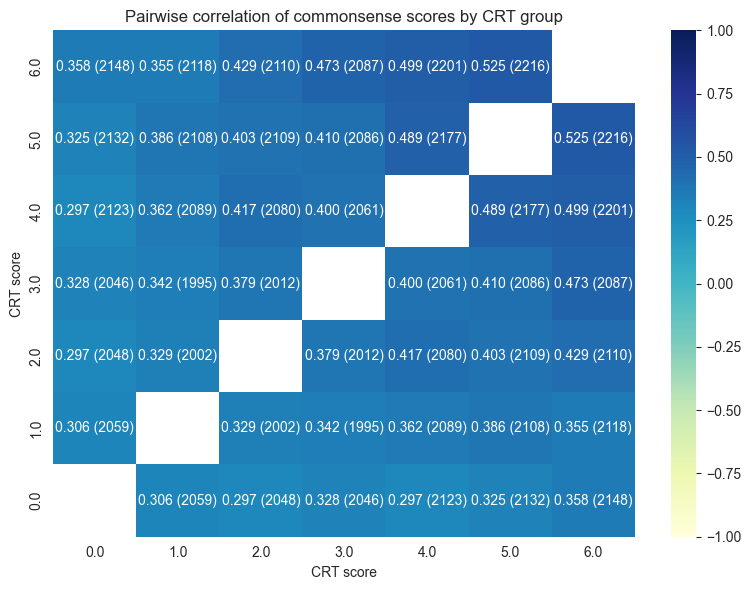

In [183]:
df = do_corrolations(group_commonsensicality_df, "crt_score", True)


unique_crt = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
n_groups = len(unique_crt)
corr_matrix = np.zeros((n_groups, n_groups), dtype=float)
count_matrix = np.zeros((n_groups, n_groups), dtype=int)


for i, crt_i in enumerate(unique_crt):
    for j, crt_j in enumerate(unique_crt):
        filtered_corr = df.filter((pl.col("x") == crt_i) & (pl.col("y") == crt_j))
        if not filtered_corr.is_empty():
            c = filtered_corr.select("correlation").to_series()[0]
        else:
            c = np.nan

        corr_matrix[i, j] = c

        count_matrix[i, j] = (
            filtered_corr.select("n").to_series()[0]
            if not filtered_corr.is_empty()
            else 0
        )


annot = np.empty((n_groups, n_groups), dtype=object)
for i in range(n_groups):
    for j in range(n_groups):
        val = corr_matrix[i, j]
        if np.isnan(val):
            annot[i, j] = ""
        else:
            annot[i, j] = f"{val:.3f} ({count_matrix[i,j]})"


plt.figure(figsize=(8, 6))
ax = sns.heatmap(
    corr_matrix,
    annot=annot,
    fmt="",
    xticklabels=unique_crt,
    yticklabels=unique_crt,
    cmap="YlGnBu",
    vmin=-1,
    vmax=1,
)
ax.invert_yaxis()
plt.xlabel("CRT score")
plt.ylabel("CRT score")
plt.title("Pairwise correlation of commonsense scores by CRT group")
plt.tight_layout()
plt.show()

Correlation std: nan


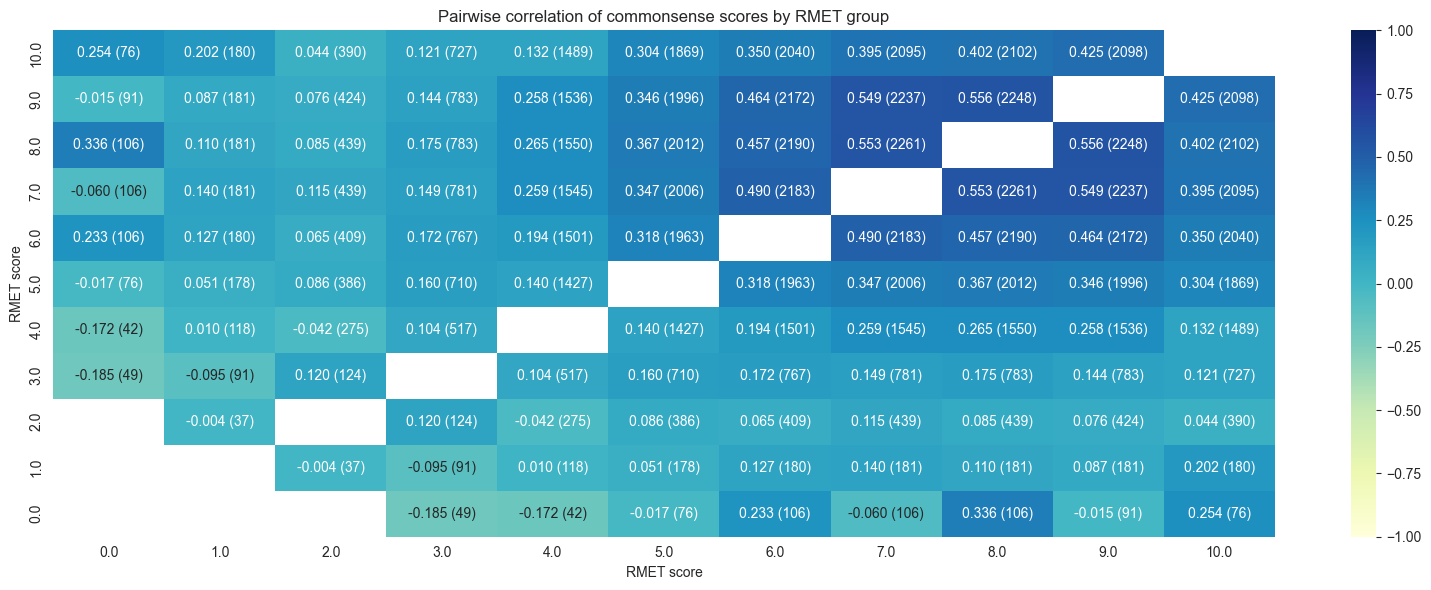

In [184]:
data = do_corrolations(group_commonsensicality_df, "rmeTen_score", True)


unique_rmet = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
n_groups = len(unique_rmet)
corr_matrix = np.zeros((n_groups, n_groups), dtype=float)
count_matrix = np.zeros((n_groups, n_groups), dtype=int)


for i, rmet_i in enumerate(unique_rmet):
    for j, rmet_j in enumerate(unique_rmet):
        filtered_corr = data.filter((pl.col("x") == rmet_i) & (pl.col("y") == rmet_j))
        if not filtered_corr.is_empty():
            c = filtered_corr.select("correlation").to_series()[0]
        else:
            c = np.nan

        corr_matrix[i, j] = c

        count_matrix[i, j] = (
            filtered_corr.select("n").to_series()[0]
            if not filtered_corr.is_empty()
            else 0
        )


annot = np.empty((n_groups, n_groups), dtype=object)
for i in range(n_groups):
    for j in range(n_groups):
        val = corr_matrix[i, j]
        if np.isnan(val):
            annot[i, j] = ""
        else:
            annot[i, j] = f"{val:.3f} ({count_matrix[i,j]})"


plt.figure(figsize=(16, 6))
ax = sns.heatmap(
    corr_matrix,
    annot=annot,
    fmt="",
    xticklabels=unique_rmet,
    yticklabels=unique_rmet,
    cmap="YlGnBu",
    vmin=-1,
    vmax=1,
)
ax.invert_yaxis()
plt.xlabel("RMET score")
plt.ylabel("RMET score")
plt.title("Pairwise correlation of commonsense scores by RMET group")
plt.tight_layout()
plt.show()

In [185]:
do_corrolations_grouped(group_commonsensicality_df, 'country_reside', 'crt_score')

country_reside_crt_score,country_reside_crt_score_2,full_correlation,boot_correlation,n,correlation
str,str,f64,f64,u32,f64
"""Ireland_3.0""","""United States_5.0""",-0.138941,0.7,44,-0.138941
"""New Zealand_4.0""","""United Kingdom_4.0""",0.103716,0.7,141,0.103716
"""United States_1.0""","""Portugal_4.0""",-0.078,0.7,56,-0.078
"""United States_0.0""","""India_2.0""",0.216732,0.7,199,0.216732
"""India_1.0""","""Spain_3.0""",-0.133631,0.7,15,-0.133631
…,…,…,…,…,…
"""Canada_4.0""","""Canada_2.0""",0.179425,0.7,22,0.179425
"""Australia_4.0""","""Mexico_3.0""",NaN,0.7,5,NaN
"""Germany_5.0""","""Italy_0.0""",0.218218,0.7,15,0.218218


In [186]:
unique_crt = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
countries = ["United States", "United Kingdom"]

for i, ct in enumerate(countries):
    print(f"Country: {ct}")

Country: United States
Country: United Kingdom


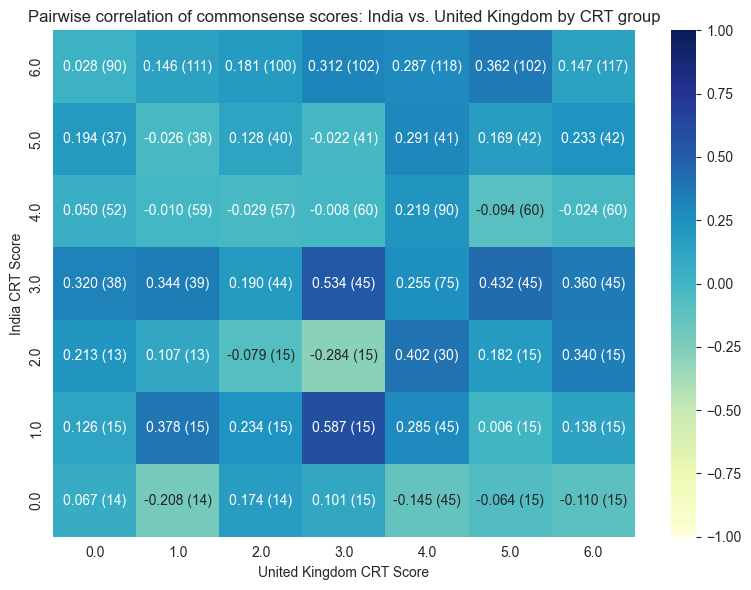

In [189]:
double_corr_df = do_corrolations_grouped(
    group_commonsensicality_df, "country_reside", "crt_score"
)
unique_crt = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
first_country = "India"
second_country = "United Kingdom"
n_groups = len(unique_crt)


corr_matrix = np.zeros((n_groups, n_groups), dtype=float)
count_matrix = np.zeros((n_groups, n_groups), dtype=int)

for i, crt_i in enumerate(unique_crt):
    for j, crt_j in enumerate(unique_crt):
        filtered_corr = double_corr_df.filter(
            (pl.col("country_reside_crt_score") == f"{first_country}_{crt_i}")
            & (pl.col("country_reside_crt_score_2") == f"{second_country}_{crt_j}")
        )
        if not filtered_corr.is_empty():
            c = filtered_corr.select("correlation").to_series()[0]
        else:
            c = np.nan
        corr_matrix[i, j] = c
        count_matrix[i, j] = (
            filtered_corr.select("n").to_series()[0]
            if not filtered_corr.is_empty()
            else 0
        )


annot = np.empty((n_groups, n_groups), dtype=object)
for i in range(n_groups):
    for j in range(n_groups):
        val = corr_matrix[i, j]
        if np.isnan(val):
            annot[i, j] = ""
        else:
            annot[i, j] = f"{val:.3f} ({count_matrix[i,j]})"


plt.figure(figsize=(8, 6))
ax = sns.heatmap(
    corr_matrix,
    annot=annot,
    fmt="",
    xticklabels=unique_crt,
    yticklabels=unique_crt,
    cmap="YlGnBu",
    vmin=-1,
    vmax=1,
)
ax.invert_yaxis()
plt.xlabel(f"{second_country} CRT Score")
plt.ylabel(f"{first_country} CRT Score")
plt.title(
    f"Pairwise correlation of commonsense scores: {first_country} vs. {second_country} by CRT group"
)
plt.tight_layout()
plt.show()

In [ ]:
countries_with_more_than_50 = (
    group_commonsensicality_df.group_by("userSessionId", "country_reside")
    .agg([pl.len().alias("n_answers")])
    .group_by("country_reside")
    .agg([pl.col("n_answers").len()])
    .filter(pl.col("n_answers") > 50)
    .sort("n_answers")
    .head(10)["country_reside"]
    .to_list()
)


relevant_plots = [
    "crt_score",
    "rmeTen_score",
    "gender",
    "marital_status",
    "language_primary",
    "english_written",
    "english_spoken",
    "employment_status",
]

for p in relevant_plots:

    unique_vals = (
        group_commonsensicality_df.filter(pl.col(p).is_not_null())
        .select(p)
        .unique()
        .to_series()
        .to_list()
    )

    if unique_vals and isinstance(unique_vals[0], (int, float)):
        unique_vals = sorted(unique_vals)

    n_groups = len(unique_vals)

    # Compute the pairwise correlations over the combined country x variable groups.
    double_corr_df = do_corrolations_grouped(
        group_commonsensicality_df, "country_reside", p
    )

    with PdfPages(f"figures/country_{p}_heatmaps.pdf") as pdf:
        # Cycle through all ordered pairs of distinct countries.
        for first_country in countries_with_more_than_50:
            for second_country in countries_with_more_than_50:
                if first_country == second_country:
                    continue  # Skip same-country comparisons

                # Prepare empty matrices for correlations and counts.
                corr_matrix = np.zeros((n_groups, n_groups), dtype=float)
                count_matrix = np.zeros((n_groups, n_groups), dtype=int)

                # Fill the matrices by filtering double_corr_df.
                for i, crt_i in enumerate(unique_vals):
                    for j, crt_j in enumerate(unique_vals):
                        # Here we assume that the labels were formed as "country_crt", e.g.
                        # "United States_2.0" on one side and "United Kingdom_3.0" on the other.
                        filtered_corr = double_corr_df.filter(
                            (
                                pl.col(f"country_reside_{p}")
                                == f"{first_country}_{crt_i}"
                            )
                            & (
                                pl.col(f"country_reside_{p}_2")
                                == f"{second_country}_{crt_j}"
                            )
                        )
                        if not filtered_corr.is_empty():
                            correlation = filtered_corr.select(
                                "correlation"
                            ).to_series()[0]
                            n_val = filtered_corr.select("n").to_series()[0]
                        else:
                            correlation = np.nan
                            n_val = 0
                        corr_matrix[i, j] = correlation
                        count_matrix[i, j] = n_val

                # Create an annotation matrix with the correlation and count.
                annot = np.empty((n_groups, n_groups), dtype=object)
                for i in range(n_groups):
                    for j in range(n_groups):
                        val = corr_matrix[i, j]
                        if np.isnan(val):
                            annot[i, j] = ""
                        else:
                            annot[i, j] = f"{val:.3f} ({count_matrix[i,j]})"

                # Plot the heatmap.
                plt.figure(figsize=(12, 10))
                ax = sns.heatmap(
                    corr_matrix,
                    annot=annot,
                    fmt="",
                    xticklabels=unique_vals,
                    yticklabels=unique_vals,
                    cmap="YlGnBu",
                    vmin=-1,
                    vmax=1,
                )
                ax.invert_yaxis()
                plt.xlabel(f"{second_country} {p}")
                plt.ylabel(f"{first_country} {p}")
                plt.title(
                    f"Pairwise correlation of commonsense scores by {p} group:\n{first_country} vs. {second_country}"
                )
                plt.tight_layout()
                pdf.savefig()
                plt.close()

In [77]:
countries_with_more_than_50 = (
    group_commonsensicality_df.group_by("userSessionId", "country_reside")
    .agg([pl.len().alias("n_answers")])
    .group_by("country_reside")
    .agg([pl.col("n_answers").len()])
    .filter(pl.col("n_answers") > 50)
    .sort("n_answers")
    .head(10)["country_reside"]
    .to_list()
)

relevant_plots = [
    "crt_score",
    "rmeTen_score",
    "birth_year",
    "gender",
    "marital_status",
    "language_primary",
    "english_written",
    "english_spoken",
    "employment_status",
    "country_reside",
]

for p in relevant_plots:

    unique_vals = (
        group_commonsensicality_df.filter(pl.col(p).is_not_null())
        .select(p)
        .unique()
        .to_series()
        .to_list()
    )

    if unique_vals and isinstance(unique_vals[0], (int, float)):
        unique_vals = sorted(unique_vals)

    n_groups = len(unique_vals)

    with PdfPages(f"figures/{p}_heatmaps_by_country.pdf") as pdf:
        for country in countries_with_more_than_50:
            data = do_corrolations(
                group_commonsensicality_df.filter(pl.col("country_reside") == country),
                p,
                True,
            )

            corr_matrix = np.zeros((n_groups, n_groups), dtype=float)
            count_matrix = np.zeros((n_groups, n_groups), dtype=int)

            for i, val_i in enumerate(unique_vals):
                for j, val_j in enumerate(unique_vals):
                    filtered_corr = data.filter(
                        (pl.col("x") == val_i) & (pl.col("y") == val_j)
                    )
                    if not filtered_corr.is_empty():
                        c = filtered_corr.select("correlation").to_series()[0]
                        n_val = filtered_corr.select("n").to_series()[0]
                    else:
                        c = np.nan
                        n_val = 0

                    corr_matrix[i, j] = c
                    count_matrix[i, j] = n_val

            annot = np.empty((n_groups, n_groups), dtype=object)
            for i in range(n_groups):
                for j in range(n_groups):
                    val = corr_matrix[i, j]
                    if np.isnan(val):
                        annot[i, j] = ""
                    else:
                        annot[i, j] = f"{val:.3f} ({count_matrix[i,j]})"

            plt.figure(figsize=(16, 6))
            ax = sns.heatmap(
                corr_matrix,
                annot=annot,
                fmt="",
                xticklabels=unique_vals,
                yticklabels=unique_vals,
                cmap="YlGnBu",
                vmin=-1,
                vmax=1,
            )
            ax.invert_yaxis()
            plt.xlabel(p)
            plt.ylabel(p)
            plt.title(f"Pairwise correlation of commonsense by {p} - {country}")

            plt.tight_layout()
            pdf.savefig()
            plt.close()

Correlation std: nan
Correlation std: 0.23934893195550633
Correlation std: 0.1417978166519858
Correlation std: nan
Correlation std: 0.16153299758310788
Correlation std: 0.033766208093371344
Correlation std: 0.12627254331690652
Correlation std: nan
Correlation std: nan
Correlation std: nan
Correlation std: nan
Correlation std: nan
Correlation std: 0.11227380045270723
Correlation std: 0.24599931969052025
Correlation std: nan
Correlation std: nan
Correlation std: nan
Correlation std: nan
Correlation std: nan
Correlation std: nan
Correlation std: nan
Correlation std: 0.2380831104633727
Correlation std: 1.3877787807814457e-17
Correlation std: 1.962615573354719e-17
Correlation std: 0.1443917290584153
Correlation std: 0.10605596212573358
Correlation std: 0.1731292679001928
Correlation std: 0.18195545158992898
Correlation std: 0.2647779872600167
Correlation std: nan
Correlation std: 0.20197318756062155
Correlation std: nan
Correlation std: nan
Correlation std: 0.153079142049807
Correlation std

3. Train a model to predict out of sample on a design point (talk about the qualities of the model)

In [78]:
group_commonsensicality_df.group_by(
    "behavior", "everyday", "figure_of_speech", "judgment", "opinion", "reasoning"
).agg(
    pl.len().alias("n_answers")
).sort("n_answers", descending=True)

behavior,everyday,figure_of_speech,judgment,opinion,reasoning,n_answers
i64,i64,i64,i64,i64,i64,u32
0,1,0,0,0,0,25446
1,0,0,1,1,0,16561
0,0,0,1,1,0,7220
0,1,0,1,0,0,5906
1,1,0,1,1,0,5489
…,…,…,…,…,…,…
0,1,0,1,1,1,61
1,1,0,0,1,1,1
1,1,0,0,1,0,1
